In [2]:
import xarray as xr

ds_url = (
    "https://storage.googleapis.com/ar6-lsl-simulations-public-standard/"
    "tide-gauges/full_sample_workflows/wf_1e/ssp119/total-workflow.zarr"
)

ds = xr.open_dataset(ds_url, engine="zarr")  # <-- remove chunks="auto"
print(ds)


<xarray.Dataset> Size: 729MB
Dimensions:           (samples: 20000, years: 9, locations: 1012)
Coordinates:
  * samples           (samples) int64 160kB 0 1 2 3 ... 19996 19997 19998 19999
  * years             (years) int64 72B 2020 2030 2040 2050 ... 2080 2090 2100
  * locations         (locations) int64 8kB 1 2 3 5 7 ... 2329 2330 2356 2358
    lat               (locations) float64 8kB ...
    lon               (locations) float64 8kB ...
Data variables:
    sea_level_change  (samples, years, locations) float32 729MB ...
Attributes:
    citation:              In order to document the impact of these sea-level...
    description:           Total sea-level change for workflow
    extra_info_url:        https://github.com/Rutgers-ESSP/IPCC-AR6-Sea-Level...
    history:               Created Fri Jun 18 14:00:48 2021
    license:               The IPCC AR6 Sea-Level Rise Projections are licens...
    source:                FACTS: Post-processed total among available contri...
    zarr_pro

In [4]:
import numpy as np

# 1. Halmstad coordinates
halmstad_lat = 56.67446
halmstad_lon = 12.85676

# 2. Extract lat/lon arrays from the dataset
lats = ds["lat"].values    # shape: (locations,)
lons = ds["lon"].values    # shape: (locations,)

# 3. Compute approximate squared distance on the sphere (longitude scaled by cos(lat))
dist2 = (lats - halmstad_lat)**2 + ((lons - halmstad_lon) * np.cos(np.deg2rad(halmstad_lat)))**2

# 4. Index of closest tide-gauge location
idx = np.argmin(dist2)

closest_loc_id = ds["locations"].values[idx]
closest_lat = float(lats[idx])
closest_lon = float(lons[idx])

print("Closest AR6 tide-gauge location:")
print("  location id:", closest_loc_id)
print("  lat:", closest_lat)
print("  lon:", closest_lon)


Closest AR6 tide-gauge location:
  location id: 73
  lat: 57.1
  lon: 12.22


In [8]:
import pandas as pd

locs = pd.read_csv(
    "https://raw.githubusercontent.com/Rutgers-ESSP/IPCC-AR6-Sea-Level-Projections/main/location_list.txt",
    sep="\t",
    header=None,
    names=["name", "loc_id", "lat", "lon"],
)

print(locs.head())



          name  loc_id    lat    lon
0        BREST       1  48.38  -4.49
1  SWINOUJSCIE       2  53.92  14.23
2    SHEERNESS       3  51.45   0.74
3     HOLYHEAD       5  53.31  -4.62
4   CUXHAVEN_2       7  53.87   8.72


In [9]:
row = locs.loc[locs["loc_id"] == int(closest_loc_id)]
print(row)


       name  loc_id   lat    lon
55  VARBERG      73  57.1  12.22


In [10]:
# Find Varberg in the location list
varberg_rows = locs[locs["name"].str.contains("VARBERG", case=False)]
varberg_ids = varberg_rows["loc_id"].astype(int).values
print("Varberg location IDs:", varberg_ids)
print(varberg_rows)

# Extract sea-level change samples for Varberg from the AR6 dataset
# sea_level_change dims should be (samples, years, locations)
varberg_sl = ds["sea_level_change"].sel(locations=varberg_ids)

print(varberg_sl)

Varberg location IDs: [73]
       name  loc_id   lat    lon
55  VARBERG      73  57.1  12.22
<xarray.DataArray 'sea_level_change' (samples: 20000, years: 9, locations: 1)> Size: 720kB
[180000 values with dtype=float32]
Coordinates:
  * samples    (samples) int64 160kB 0 1 2 3 4 ... 19995 19996 19997 19998 19999
  * years      (years) int64 72B 2020 2030 2040 2050 2060 2070 2080 2090 2100
  * locations  (locations) int64 8B 73
    lat        (locations) float64 8B 57.1
    lon        (locations) float64 8B 12.22
Attributes:
    units:    mm


In [11]:
# Squeeze locations so we only have (samples, years)
varberg_sl_da = varberg_sl.squeeze("locations", drop=True)

# Original AR6 years and values
years_ar6 = varberg_sl_da["years"].values.astype(int)  # e.g. [2020, 2030, ...]
sl_vals = varberg_sl_da.values                         # shape: (n_samples, n_years)

# Target annual years: from 2010 back to last AR6 year
start_year = 2010
end_year = int(years_ar6.max())
target_years = np.arange(start_year, end_year + 1)

n_samples, n_years = sl_vals.shape
X_annual = np.empty((n_samples, target_years.size), dtype=float)

for j in range(n_samples):
    y = sl_vals[j, :]
    t0, t1 = years_ar6[0], years_ar6[1]
    slope0 = (y[1] - y[0]) / (t1 - t0)

    # Backward (t < first AR6 year): linear extrapolation using first two AR6 points
    mask_back = target_years < t0
    X_annual[j, mask_back] = y[0] + slope0 * (target_years[mask_back] - t0)

    # From first AR6 year onward: linear interpolation between AR6 points
    mask_main = ~mask_back
    X_annual[j, mask_main] = np.interp(target_years[mask_main], years_ar6, y)

# Wrap back into an xarray DataArray for convenience
varberg_sl_annual = xr.DataArray(
    X_annual,
    dims=("samples", "year"),
    coords={"samples": varberg_sl_da["samples"], "year": target_years},
    name="sea_level_change_annual",
)

print(varberg_sl_annual)


<xarray.DataArray 'sea_level_change_annual' (samples: 20000, year: 91)> Size: 15MB
array([[ 58. ,  57. ,  56. , ..., 100.4, 116.2, 132. ],
       [ 52. ,  57. ,  62. , ..., 234.4, 223.7, 213. ],
       [ 13. ,  11.4,   9.8, ..., -37. , -43.5, -50. ],
       ...,
       [-19. , -20.6, -22.2, ...,  38.2,  57.1,  76. ],
       [ 21. ,  23.2,  25.4, ..., 106.6, 101.3,  96. ],
       [ -1. ,   1.7,   4.4, ..., 228.8, 233.9, 239. ]], shape=(20000, 91))
Coordinates:
  * samples  (samples) int64 160kB 0 1 2 3 4 5 ... 19995 19996 19997 19998 19999
  * year     (year) int64 728B 2010 2011 2012 2013 2014 ... 2097 2098 2099 2100


In [ ]:
# Assume you have an xarray.DataArray called `varberg_sl_annual`
# with dims like ("sample", "year") and a "year" coordinate.

years = varberg_sl_annual["year"].values
sl_samples = varberg_sl_annual.values.astype("float32")  # smaller file, enough precision

# Save compressed for efficient storage / loading later
np.savez_compressed(
    "data/data/varberg_sl_annual_2010_2200.npz",
    years=years,
    sl=sl_samples,
)


In [1]:
import numpy as np
# Example of how to load it later:
data = np.load("data/varberg_sl_annual_2010_2200.npz")
years = data["years"]
sl_samples = data["sl"]

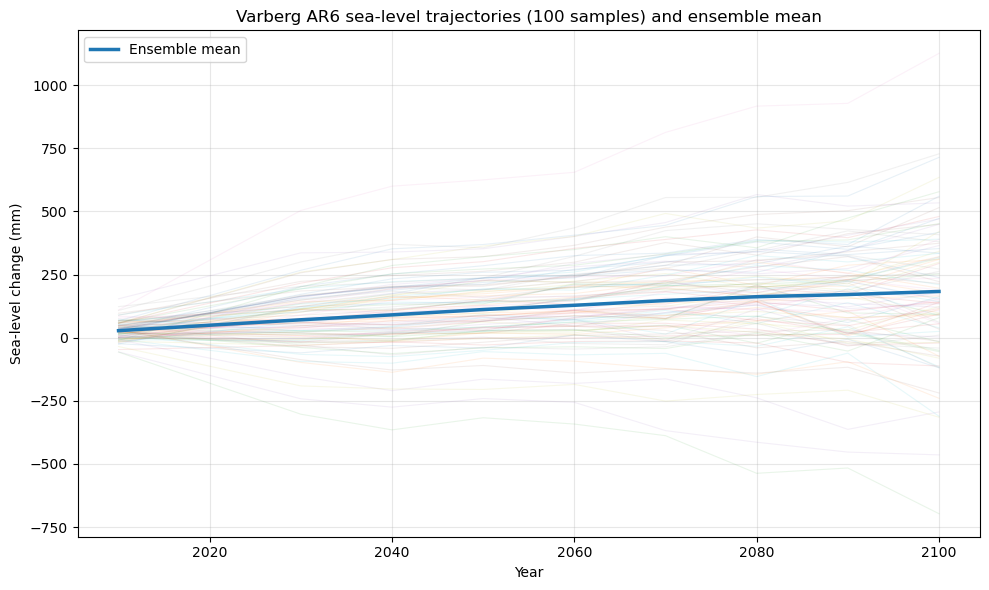

In [2]:
import matplotlib.pyplot as plt


n_samples = sl_samples.shape[0]
n_plot = min(100, n_samples)

# Pick 100 random sample paths (or fewer if <100 available)
rng = np.random.default_rng()
idx = rng.choice(n_samples, size=n_plot, replace=False)

plt.figure(figsize=(10, 6))

# Plot the random sample paths
for j in idx:
    plt.plot(years, sl_samples[j, :], alpha=0.1, linewidth=0.8)

# Plot the ensemble mean
mean_path = sl_samples.mean(axis=0)
plt.plot(years, mean_path, linewidth=2.5, label="Ensemble mean")

plt.xlabel("Year")
plt.ylabel("Sea-level change (mm)")
plt.title("Varberg AR6 sea-level trajectories (100 samples) and ensemble mean")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# CELL 1 – Load and clean Halmstad data (2010–2024, cm)

import pandas as pd
import matplotlib.pyplot as plt

# File is assumed to be in the same directory as the notebook
file_path = "data/HALMSTAD SJÖV - RH 2000.csv"

# Load CSV (semicolon-separated, header on first row)
df = pd.read_csv(file_path, sep=";", encoding="utf-8")

# Parse datetime and set as index
df["datetime"] = pd.to_datetime(df["Datum Tid (UTC)"])
df = df.set_index("datetime")

# Keep only the sea level column (in cm) and rename it
df = df[["Havsvattenstånd"]].copy()
df = df.rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to 2010–2024
df = df.loc["2010-01-01":"2024-12-31"]

# Drop any remaining missing values (should be rare)
df = df.dropna(subset=["sea_level_cm"])

print(df.head())
print(df.tail())
print("Number of observations in 2010–2024:", len(df))


                     sea_level_cm
datetime                         
2010-01-01 00:00:00         -20.3
2010-01-01 01:00:00         -24.6
2010-01-01 02:00:00         -25.5
2010-01-01 03:00:00         -24.1
2010-01-01 04:00:00         -21.9
                     sea_level_cm
datetime                         
2024-12-31 19:00:00          56.0
2024-12-31 20:00:00          49.1
2024-12-31 21:00:00          60.1
2024-12-31 22:00:00          63.0
2024-12-31 23:00:00          54.4
Number of observations in 2010–2024: 127824


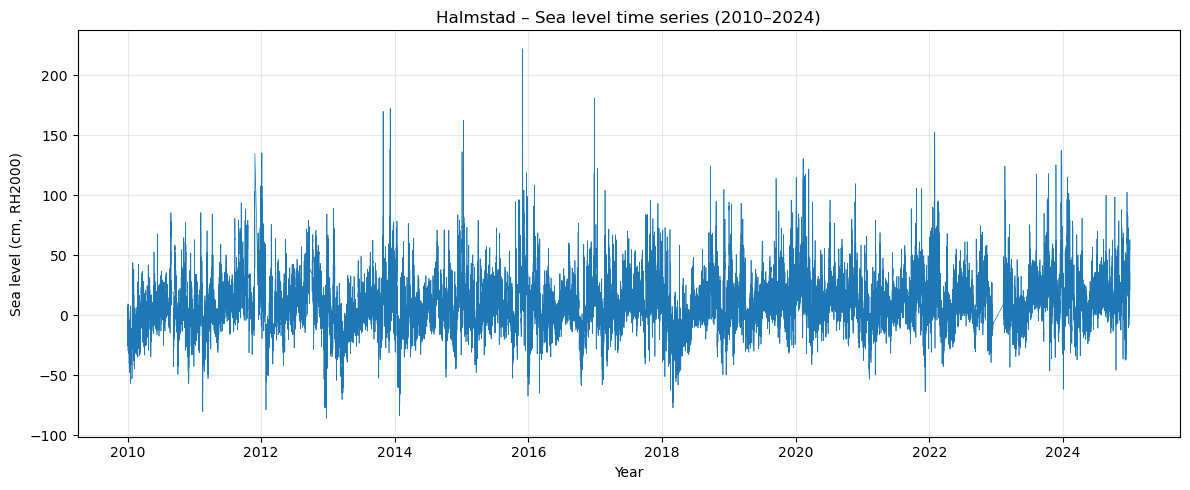

In [4]:
# CELL 2 – Plot full sea-level time series (2010–2024, cm)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df.index, df["sea_level_cm"], linewidth=0.5)
ax.set_title("Halmstad – Sea level time series (2010–2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Sea level (cm, RH2000)")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\johan\AppData\Local\Temp\ipykernel_49624\1380621011.py:4: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_max = df["sea_level_cm"].resample("A").max()


Annual block maxima (cm):
datetime
2010     85.4
2011    134.7
2012    135.4
2013    172.2
2014     83.7
2015    222.0
2016    180.8
2017    122.6
2018    124.5
2019    114.0
2020    130.6
2021    105.8
2022    152.6
2023    137.4
2024    115.0
Name: sea_level_cm, dtype: float64


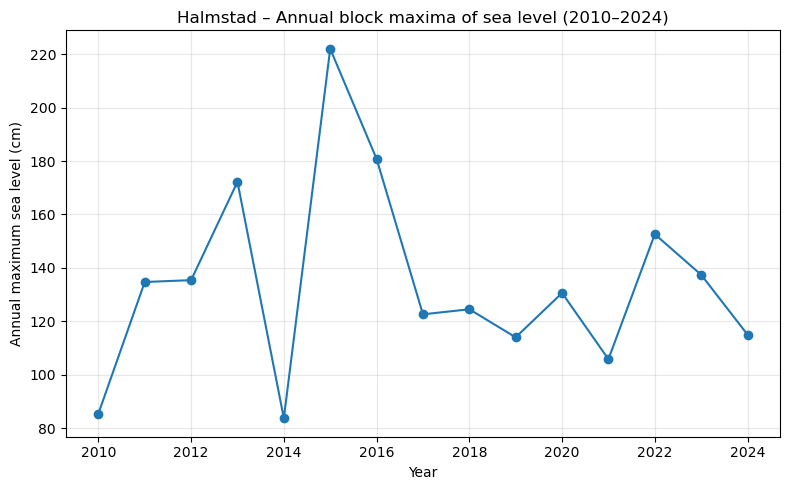

In [5]:
# CELL 3 – Annual block maxima (classic EVT block-maxima series)

# Annual maxima (calendar years)
annual_max = df["sea_level_cm"].resample("A").max()
annual_max.index = annual_max.index.year  # use year as index label

print("Annual block maxima (cm):")
print(annual_max)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(annual_max.index, annual_max.values, marker="o", linestyle="-")
ax.set_title("Halmstad – Annual block maxima of sea level (2010–2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Annual maximum sea level (cm)")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


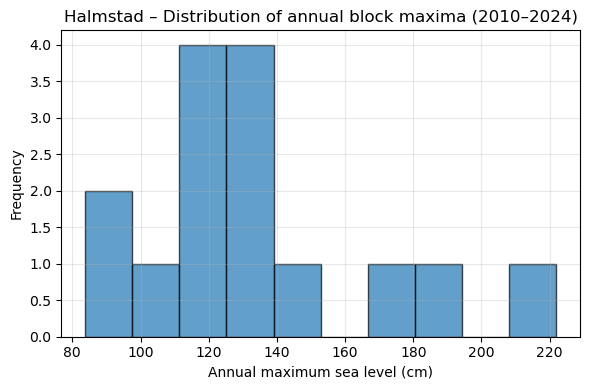

In [6]:
# CELL 4 – Histogram of annual block maxima (EVT diagnostic)

fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(annual_max.values, bins=10, edgecolor="black", alpha=0.7)
ax.set_title("Halmstad – Distribution of annual block maxima (2010–2024)")
ax.set_xlabel("Annual maximum sea level (cm)")
ax.set_ylabel("Frequency")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\johan\AppData\Local\Temp\ipykernel_49624\1878423156.py:9: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_mean = df["sea_level_cm"].resample("A").mean()
C:\Users\johan\AppData\Local\Temp\ipykernel_49624\1878423156.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_max = df["sea_level_cm"].resample("A").max()


=== Annual MEAN sea level (cm) ===
Slope (per year): 0.7565 cm/year
p-value for nonzero slope: 0.01099
R-squared: 0.403

=== Annual MAXIMUM sea level (cm) ===
Slope (per year): -0.3136 cm/year
p-value for nonzero slope: 0.8912
R-squared: 0.001



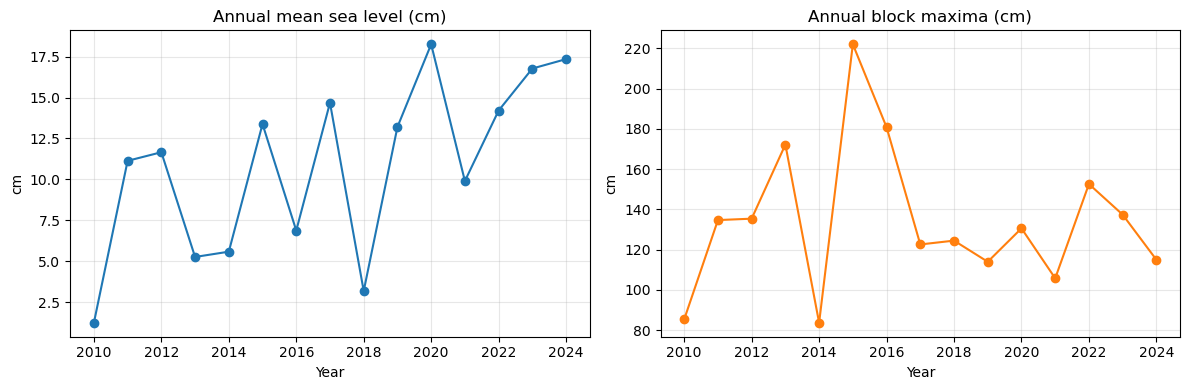

In [7]:
# CELL – Trend tests for annual mean and annual block maxima

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# 1. Annual mean sea level (cm)
annual_mean = df["sea_level_cm"].resample("A").mean()
annual_mean.index = annual_mean.index.year  # use year as integer index

# 2. Annual block maxima (cm)
annual_max = df["sea_level_cm"].resample("A").max()
annual_max.index = annual_max.index.year

# Put years into a numeric array
years_mean = annual_mean.index.values.astype(float)
years_max = annual_max.index.values.astype(float)

# Center years to reduce collinearity (optional but nice)
years_mean_c = years_mean - years_mean.mean()
years_max_c = years_max - years_max.mean()

# 3. Linear trend test for annual mean (OLS slope != 0)
slope_mean, intercept_mean, r_mean, p_mean, stderr_mean = stats.linregress(
    years_mean_c, annual_mean.values
)

# 4. Linear trend test for annual maxima (OLS slope != 0)
slope_max, intercept_max, r_max, p_max, stderr_max = stats.linregress(
    years_max_c, annual_max.values
)

print("=== Annual MEAN sea level (cm) ===")
print(f"Slope (per year): {slope_mean:.4f} cm/year")
print(f"p-value for nonzero slope: {p_mean:.4g}")
print(f"R-squared: {r_mean**2:.3f}")
print()

print("=== Annual MAXIMUM sea level (cm) ===")
print(f"Slope (per year): {slope_max:.4f} cm/year")
print(f"p-value for nonzero slope: {p_max:.4g}")
print(f"R-squared: {r_max**2:.3f}")
print()

# Quick visual check
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(annual_mean.index, annual_mean.values, marker="o")
axes[0].set_title("Annual mean sea level (cm)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("cm")
axes[0].grid(alpha=0.3)

axes[1].plot(annual_max.index, annual_max.values, marker="o", color="tab:orange")
axes[1].set_title("Annual block maxima (cm)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("cm")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\johan\AppData\Local\Temp\ipykernel_49624\2203644971.py:8: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  max_values = df["sea_level_cm"].resample("A").max()
C:\Users\johan\AppData\Local\Temp\ipykernel_49624\2203644971.py:12: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  max_times = df["sea_level_cm"].resample("A").apply(lambda s: s.idxmax())


Month of annual maximum for each year:
    year  month
0   2010      8
1   2011     11
2   2012      1
3   2013     12
4   2014     12
5   2015     11
6   2016     12
7   2017      1
8   2018      9
9   2019      9
10  2020      2
11  2021     10
12  2022      1
13  2023     12
14  2024      1


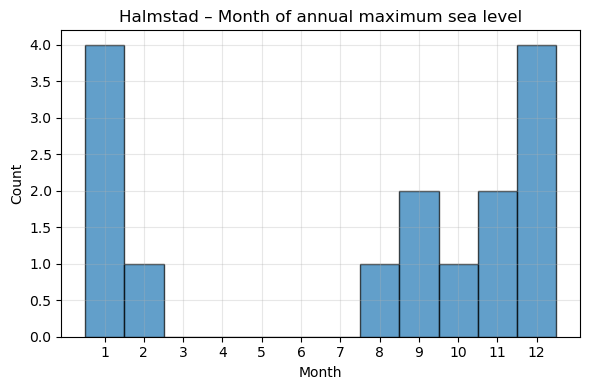

In [8]:
# CELL – Month-of-year of annual maxima (seasonality check, fixed)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Recompute annual maxima and their timestamps
max_values = df["sea_level_cm"].resample("A").max()

# For each year, take the timestamp where the maximum occurs
# (older pandas versions don't have Resampler.idxmax, so we use apply)
max_times = df["sea_level_cm"].resample("A").apply(lambda s: s.idxmax())

max_values.index = max_values.index.year
max_times.index = max_times.index.year

max_months = max_times.dt.month  # 1=Jan, ..., 12=Dec

print("Month of annual maximum for each year:")
print(pd.DataFrame({"year": max_months.index, "month": max_months.values}))

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(max_months.values, bins=np.arange(1, 14) - 0.5, edgecolor="black", alpha=0.7)
ax.set_xticks(range(1, 13))
ax.set_xlabel("Month")
ax.set_ylabel("Count")
ax.set_title("Halmstad – Month of annual maximum sea level")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
# CELL 1 – Reload full Halmstad series and keep 2009–2025 (cm)

import pandas as pd
import matplotlib.pyplot as plt

file_path = "data/HALMSTAD SJÖV - RH 2000.csv"

# Load CSV (semicolon-separated, header on first row)
df_full = pd.read_csv(file_path, sep=";", encoding="utf-8")

# Parse datetime and set as index
df_full["datetime"] = pd.to_datetime(df_full["Datum Tid (UTC)"])
df_full = df_full.set_index("datetime")

# Keep only the sea level column (in cm) and rename it
df_full = df_full[["Havsvattenstånd"]].copy()
df_full = df_full.rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to a broad window around 2009–2025 (in case the file is larger)
df_full = df_full.loc["2009-01-01":"2025-12-31"]

print(df_full.head())
print(df_full.tail())
print("Number of observations 2009–2025:", len(df_full))


                     sea_level_cm
datetime                         
2009-04-27 15:00:00          -6.2
2009-04-27 16:00:00          -5.7
2009-04-27 17:00:00          -6.8
2009-04-27 18:00:00          -2.2
2009-04-27 19:00:00           5.7
                     sea_level_cm
datetime                         
2025-11-02 20:00:00          39.4
2025-11-02 21:00:00          36.8
2025-11-02 22:00:00          34.4
2025-11-02 23:00:00          33.9
2025-11-03 00:00:00          32.0
Number of observations 2009–2025: 140713


## Latent-covariate GEV model

We will use storm-year (Jul–Jun) block maxima $Y_t$ as our extreme-value data.  
Let $t$ index storm-years: $t = t_0, \dots, t_T$.

---

### 1. Latent mean sea-level (MSL) path $X_t$

We treat $X_{t_0:T}$ as latent, with prior given by the AR6 ensemble:
$$
X_{t_0:T} \sim p_{\mathrm{AR6}}(X_{t_0:T}),
$$
where $p_{\mathrm{AR6}}$ is approximated by the empirical distribution
of AR6 Varberg sample paths (after interpolation, back-extension, and
unit conversion).

Concretely, we will have an array  
`X_prior_paths_cm[sample, year_index]`  
giving MSL in cm for each AR6 sample path and storm-year.

---

### 2. Extremes conditional on $X_t$

Given $X_t$, storm-year maxima follow a non-stationary GEV:
$$
Y_t \mid X_t, \theta \sim \mathrm{GEV}\bigl(\mu(X_t; \theta),\, \sigma(X_t; \theta),\, \xi\bigr).
$$

We use a simple parametrisation:
$$
\mu_t = \beta_0 + \beta_1 X_t, \qquad
\log \sigma_t = \alpha_0, \qquad
\xi_t = \xi.
$$

Here $X_t$ is in cm (RH2000-based), consistent with the units of $Y_t$.

---

### 3. Observed data and marginal likelihood

We observe only the storm-year maxima $Y_t$ for $t \in \{t_0, \dots, t_T\}$, not $X_t$.
For each $t$, the marginal likelihood is
$$
p(Y_t \mid \theta)
= \int p(Y_t \mid X_t, \theta)\, p_{\mathrm{AR6}}(X_t)\, dX_t.
$$

If we later fit this in a Bayesian way, the joint posterior is
$$
p(\theta, X_{t_0:T} \mid Y_{t_0:T})
\propto
\Bigl[\prod_t p(Y_t \mid X_t, \theta)\Bigr]\,
p_{\mathrm{AR6}}(X_{t_0:T})\, \pi(\theta),
$$
where $\pi(\theta)$ is the prior on the GEV parameters.

In practice we approximate $p_{\mathrm{AR6}}$ by a finite ensemble of sample paths and
treat $X_{t_0:T}$ as a latent covariate path drawn from that ensemble.

---

### Quantities we prepare

We will construct

- storm-year block maxima $Y_t$ (in cm),
- the corresponding storm-year indices,
- and an AR6-based prior matrix of $X_t$ values (in cm) for those years.


Full Halmstad series (truncated to 2009–2025):
                     sea_level_cm
datetime                         
2009-04-27 15:00:00          -6.2
2009-04-27 16:00:00          -5.7
2009-04-27 17:00:00          -6.8
2009-04-27 18:00:00          -2.2
2009-04-27 19:00:00           5.7
                     sea_level_cm
datetime                         
2025-11-02 20:00:00          39.4
2025-11-02 21:00:00          36.8
2025-11-02 22:00:00          34.4
2025-11-02 23:00:00          33.9
2025-11-03 00:00:00          32.0
Number of observations 2009–2025: 140713

Storm-year (Jul–Jun) block maxima (cm):
datetime
2010    137.4
2011     85.6
2012    135.4
2013     89.1
2014    172.2
2015    162.6
2016    222.0
2017    180.8
2018     95.4
2019    124.5
2020    130.6
2021    109.6
2022    152.6
2023    124.2
2024    137.4
2025    102.5
Name: sea_level_cm, dtype: float64


C:\Users\johan\AppData\Local\Temp\ipykernel_49624\1237045492.py:32: FutureWarning: 'A-JUN' is deprecated and will be removed in a future version, please use 'YE-JUN' instead.
  storm_year_max = series.resample("A-JUN").max()


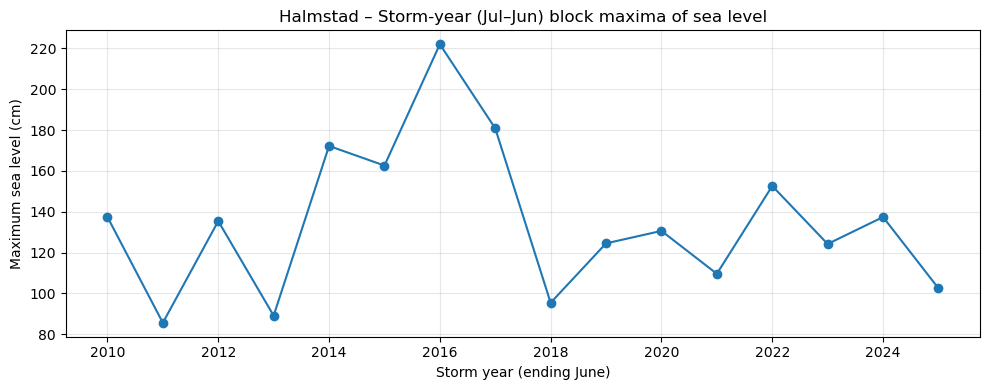

Block years: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024 2025]
Y_obs_cm shape: (16,)


In [10]:
# CELL 2 – Load Halmstad sea-level data and create storm-year (Jul–Jun) block maxima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "data/HALMSTAD SJÖV - RH 2000.csv"

# Load full Halmstad series (semicolon-separated, header on first row)
df_full = pd.read_csv(file_path, sep=";", encoding="utf-8")

# Parse datetime and set as index
df_full["datetime"] = pd.to_datetime(df_full["Datum Tid (UTC)"])
df_full = df_full.set_index("datetime")

# Keep sea level in cm and rename
df_full = df_full[["Havsvattenstånd"]].copy()
df_full = df_full.rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to a broad time window that comfortably covers 2009–2025 storm years
df_full = df_full.loc["2009-01-01":"2025-12-31"]

print("Full Halmstad series (truncated to 2009–2025):")
print(df_full.head())
print(df_full.tail())
print("Number of observations 2009–2025:", len(df_full))

# Create "storm-year" (Jul–Jun) block maxima
series = df_full["sea_level_cm"].loc["2009-07-01":"2025-06-30"]

# 'A-JUN' = annual frequency with year-end at June 30
storm_year_max = series.resample("A-JUN").max()

# Label each block by the year of the ending June
storm_year_max.index = storm_year_max.index.year
storm_year_max = storm_year_max.sort_index()

print("\nStorm-year (Jul–Jun) block maxima (cm):")
print(storm_year_max)

# Quick plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(storm_year_max.index, storm_year_max.values, marker="o")
ax.set_title("Halmstad – Storm-year (Jul–Jun) block maxima of sea level")
ax.set_xlabel("Storm year (ending June)")
ax.set_ylabel("Maximum sea level (cm)")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Extract arrays for later modelling
block_years = storm_year_max.index.values.astype(int)   # e.g. [2010, 2011, ..., 2024]
Y_obs_cm = storm_year_max.values.astype(float)          # observed block maxima (cm)

print("Block years:", block_years)
print("Y_obs_cm shape:", Y_obs_cm.shape)


In [ ]:
# CELL 3 – Load / prepare AR6-based annual MSL sample paths as prior for X_t (in cm)

import numpy as np

# OPTION A: If you still have `varberg_sl_annual` (xarray DataArray) in memory from earlier,
#           you can build from that directly. It has units in mm.
# OPTION B: If you saved it previously with np.savez_compressed as "data/varberg_sl_annual_2010_2200.npz",
#           load that here. We'll assume OPTION B for reproducibility.

# Load AR6 annual sea-level change for Varberg (mm), extended back to 2010
ar6_data = np.load("data/data/varberg_sl_annual_2010_2200.npz")
years_ar6 = ar6_data["years"].astype(int)   # e.g. [2010, 2011, ..., 2200]
sl_mm = ar6_data["sl"]                      # shape: (n_samples, n_years), in mm

print("AR6 Varberg annual sea-level change loaded:")
print("  sl_mm shape:", sl_mm.shape)
print("  years_ar6 range:", years_ar6.min(), "–", years_ar6.max())

# Convert from mm to cm to match Halmstad units
sl_cm = sl_mm / 10.0                        # 10 mm = 1 cm

# For the latent covariate prior, we need X_t for the storm-year block years.
# Our block years correspond to storm seasons Jul(Y-1)–Jun(Y). Conceptually we want
# an MSL covariate associated with "storm-year Y". For simplicity we'll align by calendar year Y.
#
# So we align AR6 years with block_years via intersection:
mask_block = np.isin(years_ar6, block_years)

if not mask_block.any():
    raise ValueError("No overlap between AR6 years and storm-year block years!")

years_for_blocks = years_ar6[mask_block]
X_prior_paths_cm = sl_cm[:, mask_block]     # shape: (n_samples, n_blocks)

print("Years used for blocks:", years_for_blocks)
print("X_prior_paths_cm shape:", X_prior_paths_cm.shape)

# Sanity check: ensure alignment between years_for_blocks and block_years
print("Block years:", block_years)


AR6 Varberg annual sea-level change loaded:
  sl_mm shape: (20000, 91)
  years_ar6 range: 2010 – 2100
Years used for blocks: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024 2025]
X_prior_paths_cm shape: (20000, 16)
Block years: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024 2025]


In [12]:
# CELL 4 – Finalize modelling inputs for the latent-X GEV model

# At this point we have:
#   - block_years: 1D array of storm-year labels (e.g. 2010,...,2024)
#   - Y_obs_cm:    1D array of observed storm-year block maxima (cm)
#   - years_for_blocks: AR6 years corresponding to columns of X_prior_paths_cm
#   - X_prior_paths_cm: 2D array [sample, year_index] of AR6-based MSL in cm
#
# For the latent-covariate model, we need X_t for *exactly* the block_years.
# If years_for_blocks and block_years are identical (in order), we are done.
# If not, we align explicitly.

# Build an index mapping AR6 years to columns
year_to_col = {y: i for i, y in enumerate(years_for_blocks)}

cols_for_blocks = []
for y in block_years:
    if y not in year_to_col:
        raise ValueError(f"Block year {y} not found in AR6 years_for_blocks.")
    cols_for_blocks.append(year_to_col[y])
cols_for_blocks = np.array(cols_for_blocks, dtype=int)

# Subset AR6 paths to match the block_year order exactly
X_block_prior_cm = X_prior_paths_cm[:, cols_for_blocks]  # shape: (n_samples, n_blocks)

print("X_block_prior_cm shape:", X_block_prior_cm.shape)
print("Number of AR6 sample paths:", X_block_prior_cm.shape[0])
print("Number of storm-year blocks:", X_block_prior_cm.shape[1])

# Summary:
#   Y_obs_cm         – observed storm-year block maxima (cm), length K
#   block_years      – corresponding storm years
#   X_block_prior_cm – AR6-based prior over latent MSL covariate paths:
#                        each row = one sample path X_t over the K storm years, in cm
#
# A generative scheme for later fitting / simulation:
#
#   1. Draw a path index m ∈ {1,...,M} uniformly (or with weights) → X^{(m)}_t.
#   2. For each block t with latent X_t = X^{(m)}_t, draw
#        Y_t | X_t, θ ∼ GEV( μ_t, σ_t, ξ ),
#      with μ_t = β_0 + β_1 X_t, log σ_t = α_0, ξ constant.
#
# For inference with latent X_t, we will combine:
#   - the empirical prior over paths given by X_block_prior_cm,
#   - the GEV likelihood p(Y_obs_cm | X_block_prior_cm, θ),
# into a joint posterior over (path index, θ), or over a more general X_t if we
# allow mixtures of paths.


X_block_prior_cm shape: (20000, 16)
Number of AR6 sample paths: 20000
Number of storm-year blocks: 16


In [15]:
# CELL 5 – Define GEV log-likelihood helper for PyMC (location–scale–shape)

import pymc as pm
import numpy as np

# Try pytensor first (PyMC v4/5); fall back to aesara (PyMC3)
try:
    import pytensor.tensor as pt
except ImportError:
    import aesara.tensor as pt

def gev_logpdf(y, mu, sigma, xi):
    """
    Log-density of GEV(y | mu, sigma, xi) in EVT convention:

        z = (y - mu) / sigma
        t = 1 + xi * z
        f(y) = 1/sigma * t^{-1/xi - 1} * exp( - t^{-1/xi} ),  t > 0

    Works elementwise; y, mu, sigma, xi can broadcast.
    """
    z = (y - mu) / sigma
    t = 1.0 + xi * z

    log_sigma = pt.log(sigma)
    inv_xi = 1.0 / xi

    # Raw log-density
    logp = -log_sigma - (inv_xi + 1.0) * pt.log(t) - t ** (-inv_xi)

    # Enforce support t > 0
    logp = pt.switch(t <= 0.0, -np.inf, logp)
    return logp


In [23]:
# CELL A – Construct historical covariate X_hist_np for the fitted years

import numpy as np

# X_block_prior_cm has shape (n_paths, K) and is aligned with Y_obs_cm
n_paths, K = X_block_prior_cm.shape
assert K == Y_obs_cm.shape[0]

# Use AR6 ensemble mean MSL (cm) for each storm-year as the covariate X_t
X_hist_np = X_block_prior_cm.mean(axis=0)    # shape (K,)

print("X_hist_np shape:", X_hist_np.shape)
print("First few X_hist_np (cm):", X_hist_np[:5])
print("First few Y_obs_cm (cm):", Y_obs_cm[:5])


X_hist_np shape: (16,)
First few X_hist_np (cm): [2.78547   3.0009675 3.216465  3.4319625 3.6474602]
First few Y_obs_cm (cm): [137.4  85.6 135.4  89.1 172.2]


In [ ]:

import pymc as pm
import numpy as np

# backend tensor: pytensor (PyMC ≥4) or aesara (PyMC3)
try:
    import pytensor.tensor as pt
except ImportError:
    import aesara.tensor as pt

Y_data_np = Y_obs_cm.astype(float)          # shape (K,)
X_prior_np = X_block_prior_cm.astype(float) # shape (M, K)

M, K = X_prior_np.shape
assert K == Y_data_np.shape[0]

# Constant tensors for the sampler
Y_const      = pt.as_tensor_variable(Y_data_np)    # (K,)
X_prior_const = pt.as_tensor_variable(X_prior_np)  # (M, K)

with pm.Model() as gev_mixture_model:
    # Basic data summaries for weakly-informative priors
    y_mean = float(Y_data_np.mean())
    y_std  = float(Y_data_np.std(ddof=1))

    # Location: μ_t^{(m)} = β0 + β1 X_t^{(m)}
    beta0 = pm.Normal("beta0", mu=y_mean, sigma=5 * max(y_std, 1.0))
    beta1 = pm.Normal("beta1", mu=1,   sigma=1)  # ~1 cm shift per 1 cm MSL

    # μ_mt: shape (M, K) – one μ_t for each path m and year t
    mu_mt = beta0 + beta1 * X_prior_const

    # Scale: log σ_t = α0 (constant over time)
    alpha0 = pm.Normal("alpha0", mu=np.log(max(y_std, 1.0)), sigma=1.0)
    sigma = pt.exp(alpha0)   # scalar; broadcast to (M, K)

    # Shape ξ
    xi = pm.Normal("xi", mu=-0.1, sigma=0.1)

    # Broadcast Y to (M, K): same Y_t across all paths m
    Y_mat = Y_const[None, :]          # shape (1, K) -> broadcast to (M, K)

    # Elementwise log-density log f_GEV(Y_t | μ_t^{(m)}, σ, ξ) for all (m,t)
    logf_mt = gev_logpdf(Y_mat, mu_mt, sigma, xi)   # shape (M, K)

    # For each t, mixture over m: p(Y_t | θ) = (1/M) Σ_m f_mt
    # Compute log p(Y_t | θ) via log-sum-exp over m
    max_logf = pt.max(logf_mt, axis=0, keepdims=True)                  # (1, K)
    stable_sum = pt.sum(pt.exp(logf_mt - max_logf), axis=0)            # (K,)
    logsumexp = pt.flatten(max_logf) + pt.log(stable_sum)              # (K,)

    # log (1/M Σ_m f_mt) = logsumexp(logf_mt) - log(M)
    log_mix_t = logsumexp - pt.log(np.array(float(M)))

    # Total log-likelihood over all years: Σ_t log p(Y_t | θ)
    loglik = pt.sum(log_mix_t)

    pm.Potential("gev_mixture_loglik", loglik)


In [32]:
import multiprocessing as mp
n_cores = 14

with gev_mixture_model:
    trace = pm.sample(
        draws=500,
        tune=2000,
        chains=n_cores,
        cores=n_cores,
        target_accept=0.9,
        random_seed=42,
    )

import arviz as az


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [beta0, beta1, alpha0, xi]


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 14 chains for 2_000 tune and 500 draw iterations (28_000 + 7_000 draws total) took 3372 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [33]:
az.summary(trace, var_names=["beta0", "beta1", "alpha0", "xi"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,115.907,9.930,97.912,135.643,0.140,0.134,5107.0,4488.0,1.0
beta1,0.918,0.956,-0.834,2.730,0.013,0.012,5260.0,4447.0,1.0
alpha0,3.469,0.214,3.079,3.878,0.003,0.003,4879.0,4721.0,1.0
xi,-0.083,0.090,-0.252,0.082,0.001,0.001,6032.0,4671.0,1.0


beta0:
  prior    mean = 135.119, sd = 183.469
  posterior mean = 115.907, sd = 9.930
  shift (post - prior) / prior_sd = -0.10
  posterior_sd / prior_sd         = 0.05

beta1:
  prior    mean = 1.000, sd = 1.000
  posterior mean = 0.918, sd = 0.956
  shift (post - prior) / prior_sd = -0.08
  posterior_sd / prior_sd         = 0.96



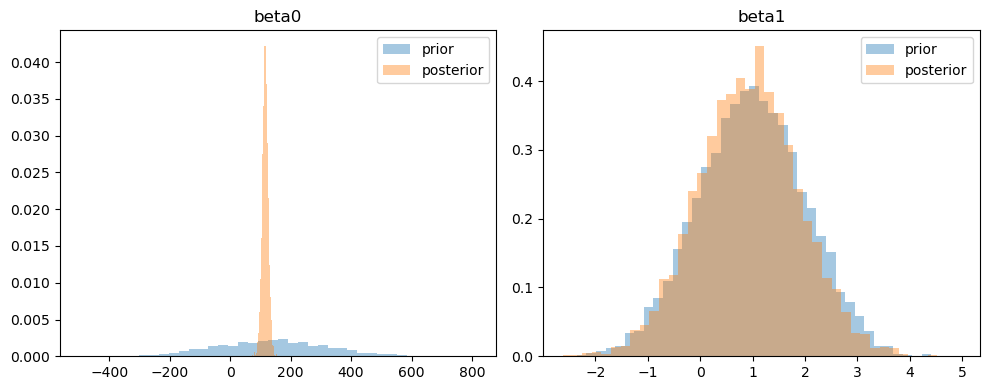

In [34]:
# CELL – Check prior vs posterior influence for beta0 and beta1

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct prior hyperparameters from your model code
prior_beta0_mu = y_mean
prior_beta0_sd = 5 * max(y_std, 1.0)

prior_beta1_mu = 1.0
prior_beta1_sd = 1

# Posterior summary from your existing trace
post = az.summary(trace, var_names=["beta0", "beta1"])

for name, prior_mu, prior_sd in [
    ("beta0", prior_beta0_mu, prior_beta0_sd),
    ("beta1", prior_beta1_mu, prior_beta1_sd),
]:
    post_mu = float(post.loc[name, "mean"])
    post_sd = float(post.loc[name, "sd"])
    z_shift = (post_mu - prior_mu) / prior_sd       # how many prior-sd the mean moved
    sd_ratio = post_sd / prior_sd                   # posterior sd / prior sd

    print(f"{name}:")
    print(f"  prior    mean = {prior_mu:.3f}, sd = {prior_sd:.3f}")
    print(f"  posterior mean = {post_mu:.3f}, sd = {post_sd:.3f}")
    print(f"  shift (post - prior) / prior_sd = {z_shift:.2f}")
    print(f"  posterior_sd / prior_sd         = {sd_ratio:.2f}")
    print()

# Visual comparison: prior vs posterior marginals
n_prior_samples = 5000
beta0_prior_samples = np.random.normal(prior_beta0_mu, prior_beta0_sd, size=n_prior_samples)
beta1_prior_samples = np.random.normal(prior_beta1_mu, prior_beta1_sd, size=n_prior_samples)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(beta0_prior_samples, bins=40, density=True, alpha=0.4, label="prior")
axes[0].hist(trace.posterior["beta0"].values.flatten(), bins=40, density=True, alpha=0.4, label="posterior")
axes[0].set_title("beta0")
axes[0].legend()

axes[1].hist(beta1_prior_samples, bins=40, density=True, alpha=0.4, label="prior")
axes[1].hist(trace.posterior["beta1"].values.flatten(), bins=40, density=True, alpha=0.4, label="posterior")
axes[1].set_title("beta1")
axes[1].legend()

plt.tight_layout()
plt.show()


alpha0:
  prior    mean = 3.603, sd = 1.000
  posterior mean = 3.469, sd = 0.214
  shift (post - prior) / prior_sd = -0.13
  posterior_sd / prior_sd         = 0.21

xi:
  prior    mean = -0.100, sd = 0.100
  posterior mean = -0.083, sd = 0.090
  shift (post - prior) / prior_sd = 0.17
  posterior_sd / prior_sd         = 0.90



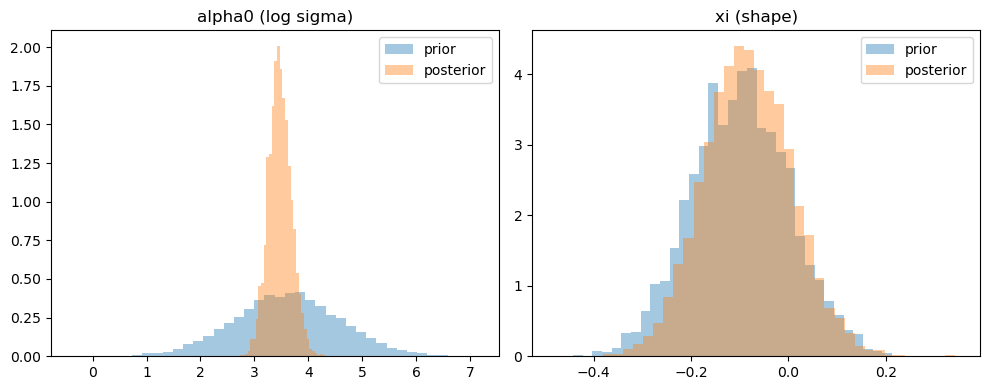

In [36]:
# CELL – Prior vs posterior diagnostics for alpha0 and xi

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct prior hyperparameters from the model
prior_alpha0_mu = np.log(max(y_std, 1.0))
prior_alpha0_sd = 1.0

prior_xi_mu = -0.1
prior_xi_sd = 0.1

# Posterior summary from your existing trace
post_ax = az.summary(trace, var_names=["alpha0", "xi"])

for name, prior_mu, prior_sd in [
    ("alpha0", prior_alpha0_mu, prior_alpha0_sd),
    ("xi",     prior_xi_mu,     prior_xi_sd),
]:
    post_mu = float(post_ax.loc[name, "mean"])
    post_sd = float(post_ax.loc[name, "sd"])
    z_shift = (post_mu - prior_mu) / prior_sd       # shift in prior SD units
    sd_ratio = post_sd / prior_sd                   # posterior sd / prior sd

    print(f"{name}:")
    print(f"  prior    mean = {prior_mu:.3f}, sd = {prior_sd:.3f}")
    print(f"  posterior mean = {post_mu:.3f}, sd = {post_sd:.3f}")
    print(f"  shift (post - prior) / prior_sd = {z_shift:.2f}")
    print(f"  posterior_sd / prior_sd         = {sd_ratio:.2f}")
    print()

# Visual comparison: prior vs posterior marginals
n_prior_samples = 5000
alpha0_prior_samples = np.random.normal(
    prior_alpha0_mu, prior_alpha0_sd, size=n_prior_samples
)
xi_prior_samples = np.random.normal(
    prior_xi_mu, prior_xi_sd, size=n_prior_samples
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(alpha0_prior_samples, bins=40, density=True, alpha=0.4, label="prior")
axes[0].hist(trace.posterior["alpha0"].values.flatten(),
             bins=40, density=True, alpha=0.4, label="posterior")
axes[0].set_title("alpha0 (log sigma)")
axes[0].legend()

axes[1].hist(xi_prior_samples, bins=40, density=True, alpha=0.4, label="prior")
axes[1].hist(trace.posterior["xi"].values.flatten(),
             bins=40, density=True, alpha=0.4, label="posterior")
axes[1].set_title("xi (shape)")
axes[1].legend()

plt.tight_layout()
plt.show()


In [27]:

az.summary(trace, var_names=["beta0", "beta1", "alpha0", "xi"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,115.488,9.316,97.601,132.802,0.063,0.066,22254.0,16649.0,1.0
beta1,0.982,0.496,0.063,1.911,0.003,0.003,25274.0,19246.0,1.0
alpha0,3.472,0.210,3.068,3.858,0.001,0.001,20600.0,18738.0,1.0
xi,-0.082,0.090,-0.259,0.077,0.001,0.001,23371.0,17556.0,1.0


beta0:
  prior    mean = 135.119, sd = 183.469
  posterior mean = 115.488, sd = 9.316
  shift (post - prior) / prior_sd = -0.11
  posterior_sd / prior_sd         = 0.05

beta1:
  prior    mean = 1.000, sd = 0.500
  posterior mean = 0.982, sd = 0.496
  shift (post - prior) / prior_sd = -0.04
  posterior_sd / prior_sd         = 0.99



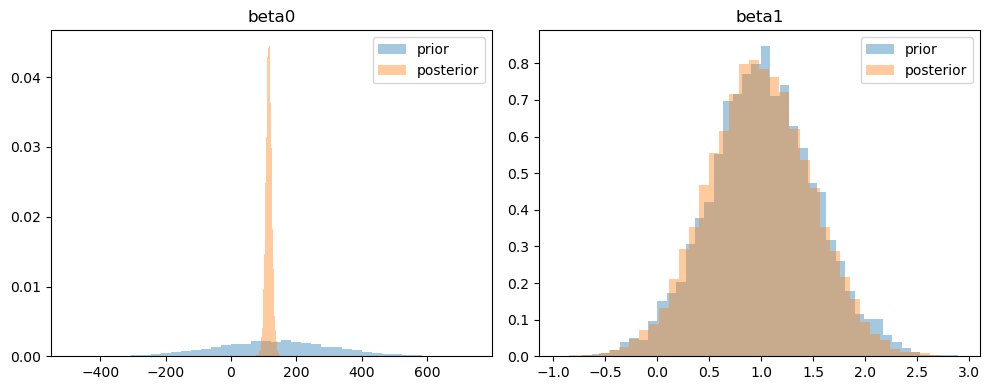

In [28]:
# CELL – Check prior vs posterior influence for beta0 and beta1

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct prior hyperparameters from your model code
prior_beta0_mu = y_mean
prior_beta0_sd = 5 * max(y_std, 1.0)

prior_beta1_mu = 1.0
prior_beta1_sd = 0.5

# Posterior summary from your existing trace
post = az.summary(trace, var_names=["beta0", "beta1"])

for name, prior_mu, prior_sd in [
    ("beta0", prior_beta0_mu, prior_beta0_sd),
    ("beta1", prior_beta1_mu, prior_beta1_sd),
]:
    post_mu = float(post.loc[name, "mean"])
    post_sd = float(post.loc[name, "sd"])
    z_shift = (post_mu - prior_mu) / prior_sd       # how many prior-sd the mean moved
    sd_ratio = post_sd / prior_sd                   # posterior sd / prior sd

    print(f"{name}:")
    print(f"  prior    mean = {prior_mu:.3f}, sd = {prior_sd:.3f}")
    print(f"  posterior mean = {post_mu:.3f}, sd = {post_sd:.3f}")
    print(f"  shift (post - prior) / prior_sd = {z_shift:.2f}")
    print(f"  posterior_sd / prior_sd         = {sd_ratio:.2f}")
    print()

# Visual comparison: prior vs posterior marginals
n_prior_samples = 5000
beta0_prior_samples = np.random.normal(prior_beta0_mu, prior_beta0_sd, size=n_prior_samples)
beta1_prior_samples = np.random.normal(prior_beta1_mu, prior_beta1_sd, size=n_prior_samples)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(beta0_prior_samples, bins=40, density=True, alpha=0.4, label="prior")
axes[0].hist(trace.posterior["beta0"].values.flatten(), bins=40, density=True, alpha=0.4, label="posterior")
axes[0].set_title("beta0")
axes[0].legend()

axes[1].hist(beta1_prior_samples, bins=40, density=True, alpha=0.4, label="prior")
axes[1].hist(trace.posterior["beta1"].values.flatten(), bins=40, density=True, alpha=0.4, label="posterior")
axes[1].set_title("beta1")
axes[1].legend()

plt.tight_layout()
plt.show()


Number of non-missing sea-level observations for POT diagnostics: 136515


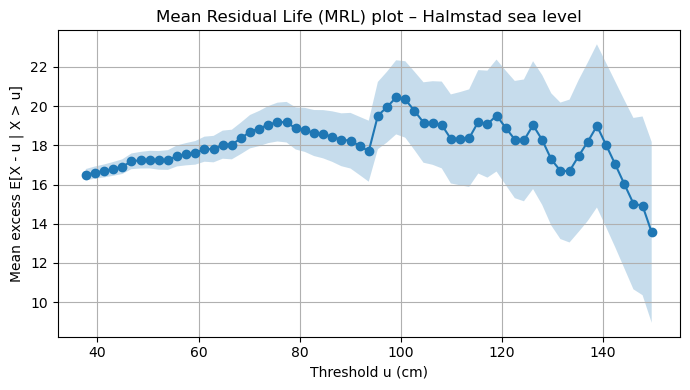

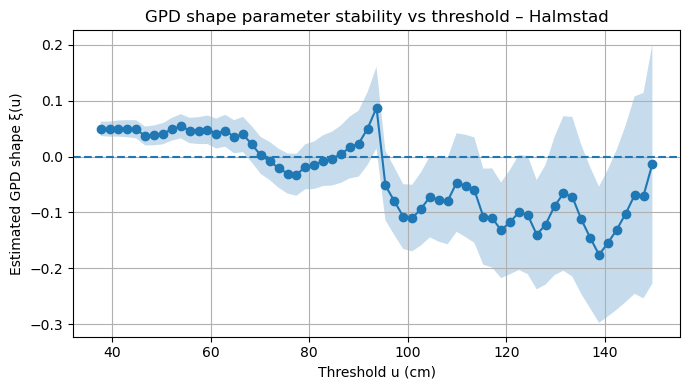

In [45]:
# CELL X – Threshold diagnostics (MRL + shape stability) for POT threshold choice
#
# Assumes:
#   - `series` is already defined as in CELL 2:
#       series = df_full["sea_level_cm"].loc["2009-07-01":"2025-06-30"]
#
# References / motivation:
#   - Davison & Smith (1990), "Models for Exceedances over High Thresholds",
#     JRSS B 52(3):393–442 – classical POT + threshold discussion.
#   - Coles (2001), "An Introduction to Statistical Modeling of Extreme Values",
#     ch. 4 – MRL plot and parameter-stability ideas.
#   - Bommier (2014), "Peaks-Over-Threshold Modelling of Environmental Data",
#     ch. 3 – derivation of the mean residual life plot and linearity property.
#   - Ribatet (2011/2024), POT package user guide – practical use of MRL and
#     parameter-stability plots (functions mrlplot, tcplot).
#   - Northrop & Coleman (2014), "Improved threshold diagnostic plots..." –
#     refinement of parameter-stability diagnostics.
#
# Key idea:
#   - For a range of candidate thresholds u, we:
#       1) Compute the empirical mean excess E[X - u | X > u] and CI (MRL plot).
#       2) Fit a GPD to exceedances X - u and track the estimated shape ξ(u)
#          and its CI (stability plot).
#   - A reasonable u is in a region where:
#       - the MRL plot is ~linear in u, and
#       - ξ(u) is ~constant (within CI) as u increases,
#     while still leaving enough exceedances for estimation.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import genpareto

# Drop missing values and work with a NumPy array of sea levels
x = series.dropna().values
n = len(x)
print(f"Number of non-missing sea-level observations for POT diagnostics: {n}")

# Choose a grid of candidate thresholds using high quantiles
# (you can adjust the range depending on how "extreme" you want to go)
q_min, q_max = 0.90, 0.999999   # from 90th to 99.999th percentile
n_u = 100                      # number of threshold values to try

u_min = np.quantile(x, q_min)
u_max = np.quantile(x, q_max)

# Equally spaced thresholds in the upper tail (big values)
u_grid = np.linspace(u_min, u_max, n_u)


# Containers for diagnostics
mrl_vals = []      # mean residual life
mrl_ci_low = []
mrl_ci_high = []
xi_hat = []        # estimated shape parameter ξ
xi_ci_low = []
xi_ci_high = []
scale_hat = []

for u in u_grid:
    # Exceedances above threshold u
    exceedances = x[x > u] - u
    nu = len(exceedances)
    if nu < 30:
        # Too few exceedances for reliable estimates; stop the loop here
        # (you can relax this if you are willing to accept more variance)
        break

    # --- 1) Mean residual life (MRL) at threshold u ---
    m = exceedances.mean()
    s = exceedances.std(ddof=1)
    se_m = s / np.sqrt(nu)
    mrl_vals.append(m)
    mrl_ci_low.append(m - 1.96 * se_m)
    mrl_ci_high.append(m + 1.96 * se_m)

    # --- 2) GPD fit at threshold u (for stability of ξ) ---
    # We fit to the exceedances with location fixed at 0
    # (standard POT practice: Y = X - u, Y > 0).
    c, loc, scale = genpareto.fit(exceedances, floc=0.0)
    xi_hat.append(c)
    scale_hat.append(scale)

    # Approximate standard error of ξ via observed Fisher information:
    #  - genpareto.fit does not return SEs, so we use a simple finite-difference
    #    approximation of the log-likelihood curvature at the MLE.
    #  - This is rough but sufficient to visualize a stability band.
    def gpd_loglik(shape, sc):
        # loglik for exceedances with loc=0
        return np.sum(genpareto.logpdf(exceedances, c=shape, loc=0.0, scale=sc))

    # perturbations for numerical second derivative
    eps = 1e-4 * max(1.0, abs(c))
    ll0 = gpd_loglik(c, scale)
    ll_plus = gpd_loglik(c + eps, scale)
    ll_minus = gpd_loglik(c - eps, scale)

    # second derivative wrt shape (approx)
    d2_ll = (ll_plus - 2 * ll0 + ll_minus) / (eps ** 2)

    if d2_ll < 0:
        se_xi = np.sqrt(-1.0 / d2_ll)
    else:
        # fallback: if curvature estimate is non-negative (numerical issues),
        # treat SE as NaN
        se_xi = np.nan

    xi_ci_low.append(c - 1.96 * se_xi if np.isfinite(se_xi) else np.nan)
    xi_ci_high.append(c + 1.96 * se_xi if np.isfinite(se_xi) else np.nan)

# Convert collected values to arrays
u_eff = u_grid[:len(mrl_vals)]
mrl_vals = np.asarray(mrl_vals)
mrl_ci_low = np.asarray(mrl_ci_low)
mrl_ci_high = np.asarray(mrl_ci_high)

xi_hat = np.asarray(xi_hat)
xi_ci_low = np.asarray(xi_ci_low)
xi_ci_high = np.asarray(xi_ci_high)

# --- Plot 1: Mean Residual Life (MRL) plot ---
plt.figure(figsize=(7, 4))
plt.plot(u_eff, mrl_vals, marker="o", linestyle="-")
plt.fill_between(u_eff, mrl_ci_low, mrl_ci_high, alpha=0.25)
plt.xlabel("Threshold u (cm)")
plt.ylabel("Mean excess E[X - u | X > u]")
plt.title("Mean Residual Life (MRL) plot – Halmstad sea level")
plt.grid(True)
plt.tight_layout()

# --- Plot 2: Shape parameter stability plot ---
plt.figure(figsize=(7, 4))
plt.plot(u_eff, xi_hat, marker="o", linestyle="-")
# Add CI band where available
valid = np.isfinite(xi_ci_low) & np.isfinite(xi_ci_high)
if valid.any():
    plt.fill_between(u_eff[valid], xi_ci_low[valid], xi_ci_high[valid], alpha=0.25)

plt.axhline(0.0, linestyle="--")  # reference (Gumbel case)
plt.xlabel("Threshold u (cm)")
plt.ylabel("Estimated GPD shape ξ(u)")
plt.title("GPD shape parameter stability vs threshold – Halmstad")
plt.grid(True)
plt.tight_layout()

plt.show()

# Interpretation (qualitative, for you as the analyst):
#   - Look at the MRL plot: choose a threshold region where the points and CI
#     are approximately linear in u (no obvious curvature), and there are still
#     enough exceedances (you can check nu for a few u's by hand).
#   - Look at the ξ(u) plot: in a good threshold range, ξ(u) should fluctuate
#     around a roughly constant value, and its CI band should overlap across
#     nearby thresholds.
#   - The overlap between:
#       (i) MRL "linear-looking" range and
#       (ii) ξ-stable range
#     gives you a defensible candidate threshold u* for POT modelling.


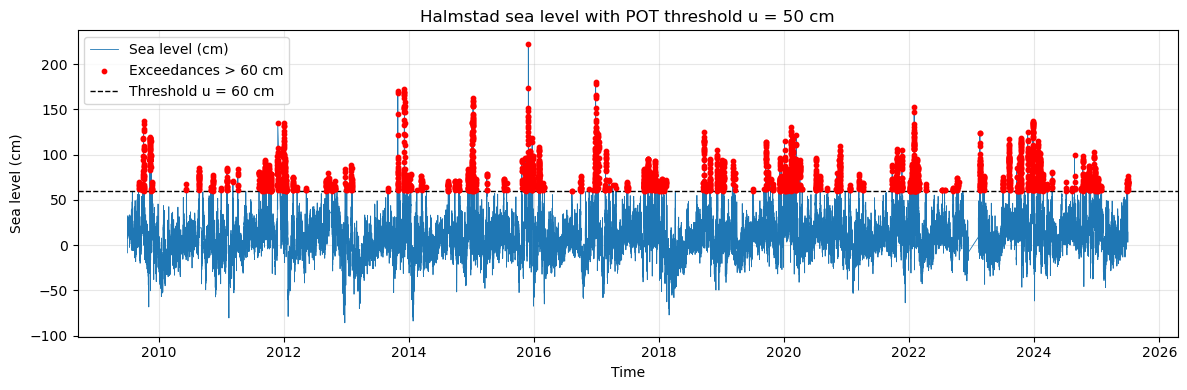

In [66]:
# CELL X – Time series with threshold u=50 cm and exceedances highlighted
#
# Idea:
#   - Plot the full sea-level series over time.
#   - Draw a horizontal line at u = 50 cm.
#   - Highlight exceedances X_t > u as red markers.
#   - If 50 cm is a "declustering" threshold, exceedances should appear
#     as relatively isolated points or short bursts around storm peaks,
#     not as long continuous high-water periods.

import matplotlib.pyplot as plt
import numpy as np

# Use the same series as before (Jul 2009–Jun 2025)
x = series

u = 60.0  # chosen threshold in cm

# Boolean mask for exceedances over the threshold
exceed_mask = x > u

plt.figure(figsize=(12, 4))

# Plot the full time series
plt.plot(x.index, x.values, linewidth=0.6, label="Sea level (cm)")

# Highlight exceedances
plt.scatter(
    x.index[exceed_mask],
    x.values[exceed_mask],
    s=10,
    color="red",
    label=f"Exceedances > {u:.0f} cm",
    zorder=3,
)

# Horizontal threshold line
plt.axhline(u, color="black", linestyle="--", linewidth=1.0,
            label=f"Threshold u = {u:.0f} cm")

plt.xlabel("Time")
plt.ylabel("Sea level (cm)")
plt.title("Halmstad sea level with POT threshold u = 50 cm")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visual interpretation for you:
#   If the red points above 50 cm appear mainly as isolated groups
#   around distinct storm peaks (with gaps of lower levels in between),
#   that supports the idea that u = 50 cm is high enough that exceedances
#   are approximately independent "storm events" (i.e. effectively
#   declustered by the threshold choice).


C:\Users\johan\AppData\Local\Temp\ipykernel_49624\141766758.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clusters = df_exc.groupby("cluster").apply(summarise_cluster)


Threshold u = 60.0 cm, run length r = 24 h
Number of raw exceedances above u: 3439
Number of clusters (storm events): 249

First few clusters:
   cluster_id          start_time            end_time            max_time  \
0           1 2009-09-05 18:00:00 2009-09-05 23:00:00 2009-09-05 20:00:00   
1           2 2009-09-28 16:00:00 2009-09-28 16:00:00 2009-09-28 16:00:00   
2           3 2009-10-03 17:00:00 2009-10-05 09:00:00 2009-10-04 18:00:00   
3           4 2009-10-07 10:00:00 2009-10-07 13:00:00 2009-10-07 11:00:00   
4           5 2009-10-08 20:00:00 2009-10-09 00:00:00 2009-10-08 21:00:00   

   max_level  size  duration_hours  
0       69.6     6             5.0  
1       60.8     1             0.0  
2      137.4    32            40.0  
3       66.6     4             3.0  
4       84.1     5             4.0  


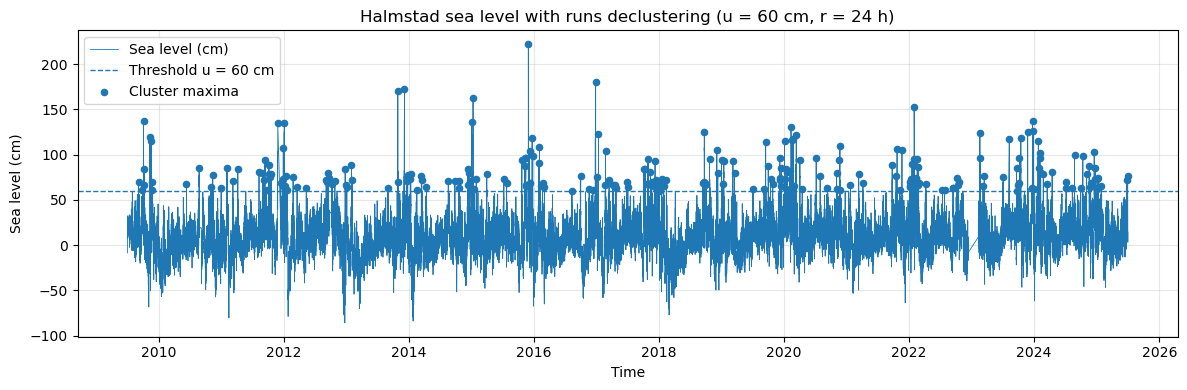

In [67]:
# CELL – Runs declustering with u = 55 cm, r = 24 h, and time plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def runs_declustering(series, u, run_hours=24.0):
    """
    Runs declustering for a univariate time series with DateTimeIndex.

    Parameters
    ----------
    series : pd.Series
        Sea level series with DateTimeIndex (sub-daily resolution).
    u : float
        Threshold for exceedances (same units as series, here cm).
    run_hours : float
        Run length r in hours. Exceedances separated by less than r hours
        are in the same cluster; gap >= r hours starts a new cluster.

    Returns
    -------
    clusters : pd.DataFrame
        One row per cluster, with:
        - cluster_id
        - start_time, end_time
        - max_time, max_level
        - size (number of exceedances in cluster)
        - duration_hours
    """

    # 1) Keep only exceedances above u
    exceed = series[series > u].dropna().sort_index()
    if exceed.empty:
        raise ValueError("No exceedances above u; choose a lower threshold.")

    # Time gaps between consecutive exceedances (in hours)
    dt_hours = exceed.index.to_series().diff().dt.total_seconds() / 3600.0

    # New cluster when gap >= run_hours (first exceedance always starts cluster 1)
    new_cluster = (dt_hours.isna()) | (dt_hours >= run_hours)
    cluster_id = new_cluster.cumsum()  # 1, 2, 3, ...

    # 2) Build a DataFrame with cluster labels
    df_exc = pd.DataFrame({
        "level": exceed.values,
        "time": exceed.index,
        "cluster": cluster_id.values,
    })

    # 3) Summarise each cluster (cluster maxima etc.)
    def summarise_cluster(g):
        max_idx = g["level"].idxmax()
        return pd.Series({
            "start_time": g["time"].min(),
            "end_time": g["time"].max(),
            "max_time": g.loc[max_idx, "time"],
            "max_level": g["level"].max(),
            "size": len(g),
            "duration_hours": (g["time"].max() - g["time"].min()).total_seconds() / 3600.0,
        })

    clusters = df_exc.groupby("cluster").apply(summarise_cluster)
    clusters.index.name = "cluster_id"
    clusters = clusters.reset_index()

    return clusters

# --- Apply runs declustering to your Halmstad series ---
u = 60.0        # threshold (cm)
run_hours = 24  # run length in hours

clusters = runs_declustering(series, u=u, run_hours=run_hours)

n_exceed = (series > u).sum()
n_clusters = len(clusters)

print(f"Threshold u = {u:.1f} cm, run length r = {run_hours} h")
print(f"Number of raw exceedances above u: {n_exceed}")
print(f"Number of clusters (storm events): {n_clusters}")
print("\nFirst few clusters:")
print(clusters.head())

# POT sample = cluster maxima
pot_sample = clusters["max_level"].values

# --- Plot time series with threshold and cluster maxima ---
plt.figure(figsize=(12, 4))

# Full series
plt.plot(series.index, series.values, linewidth=0.6, label="Sea level (cm)")

# Threshold line
plt.axhline(u, linestyle="--", linewidth=1.0, label=f"Threshold u = {u:.0f} cm")

# Cluster maxima
plt.scatter(
    clusters["max_time"],
    clusters["max_level"],
    s=20,
    label="Cluster maxima",
    zorder=3,
)

plt.xlabel("Time")
plt.ylabel("Sea level (cm)")
plt.title(f"Halmstad sea level with runs declustering (u = {u:.0f} cm, r = {run_hours} h)")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Storm-year counts of declustered exceedances (u = 60 cm, r = 24 h):
storm_year
2009    10
2010     7
2011    21
2012    11
2013    13
2014    13
2015    18
2016    14
2017    18
2018    13
2019    26
2020    11
2021    23
2022    11
2023    21
2024    19
dtype: int64

Estimated Poisson rate λ̂ (mean count per storm-year): 15.56
Sample variance of counts per storm-year: 29.06
Variance-to-mean ratio (Poisson ≈ 1): 1.87


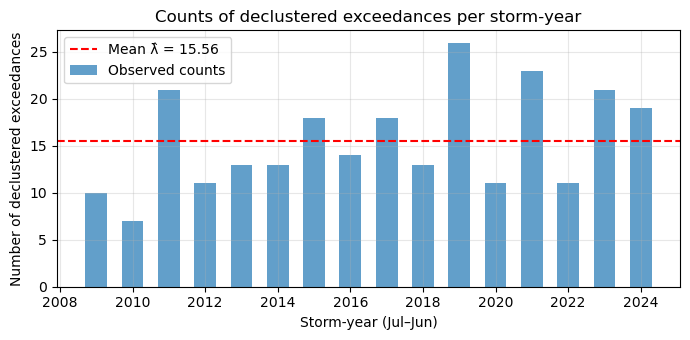

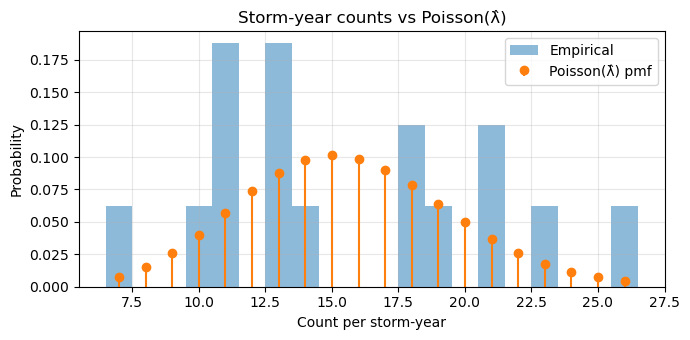

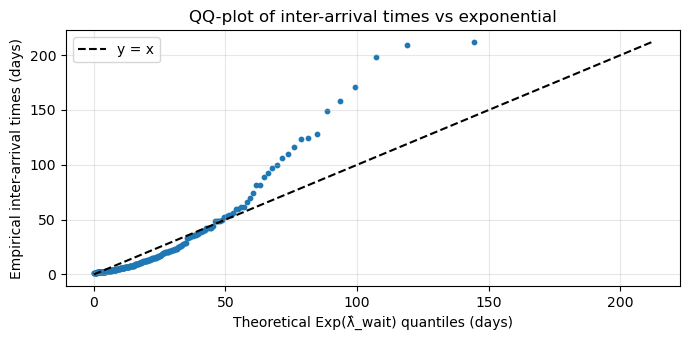

In [68]:
# CELL – Poisson diagnostics for declustered exceedances (u = 60, r = 24 h)
#
# Assumes:
#   - 'series' is your full Halmstad sea-level series (Jul 2009–Jun 2025).
#   - 'clusters' is the DataFrame from runs declustering with columns:
#       ['cluster_id', 'start_time', 'end_time', 'max_time', 'max_level', ...]
#     and threshold u = 60, run_hours = 24.
#
# This cell:
#   1) Defines storm-years (Jul–Jun) and counts clusters per storm-year.
#   2) Checks variance/mean ratio of counts (Poisson would have var ≈ mean).
#   3) Plots:
#       - counts per storm-year over time,
#       - histogram of counts with Poisson(λ̂) overlay,
#       - QQ-plot of inter-arrival times vs exponential.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, expon

# --- 1. Define storm-years (Jul–Jun) and count clusters per storm-year ---

def storm_year(ts):
    """Map a timestamp to a 'storm-year' (Jul–Jun)."""
    y = ts.year
    if ts.month >= 7:
        return y  # Jul–Dec belong to same calendar year
    else:
        return y - 1  # Jan–Jun belong to previous Jul–Jun storm-year

clusters = clusters.copy()
clusters["storm_year"] = clusters["max_time"].apply(storm_year)

counts = clusters.groupby("storm_year").size()
counts = counts.sort_index()

print("Storm-year counts of declustered exceedances (u = 60 cm, r = 24 h):")
print(counts)

lam_hat = counts.mean()
var_hat = counts.var(ddof=1)
vmr = var_hat / lam_hat if lam_hat > 0 else np.nan

print(f"\nEstimated Poisson rate λ̂ (mean count per storm-year): {lam_hat:.2f}")
print(f"Sample variance of counts per storm-year: {var_hat:.2f}")
print(f"Variance-to-mean ratio (Poisson ≈ 1): {vmr:.2f}")

# --- 2. Plot counts per storm-year over time ---

plt.figure(figsize=(7, 3.5))
plt.bar(counts.index, counts.values, width=0.6, alpha=0.7, label="Observed counts")
plt.axhline(lam_hat, color="red", linestyle="--", label=f"Mean λ̂ = {lam_hat:.2f}")
plt.xlabel("Storm-year (Jul–Jun)")
plt.ylabel("Number of declustered exceedances")
plt.title("Counts of declustered exceedances per storm-year")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# --- 3. Histogram of counts with Poisson(λ̂) overlay ---

plt.figure(figsize=(7, 3.5))

unique_vals = np.arange(counts.min(), counts.max() + 1)
hist_vals, bins, _ = plt.hist(
    counts.values,
    bins=np.arange(unique_vals.min() - 0.5, unique_vals.max() + 1.5, 1.0),
    density=True,
    alpha=0.5,
    label="Empirical"
)

pmf_vals = poisson.pmf(unique_vals, lam_hat)
plt.stem(unique_vals, pmf_vals, linefmt="C1-", markerfmt="C1o", basefmt=" ", label="Poisson(λ̂) pmf")

plt.xlabel("Count per storm-year")
plt.ylabel("Probability")
plt.title("Storm-year counts vs Poisson(λ̂)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# --- 4. QQ-plot of inter-arrival times vs exponential ---

# Sort event times and compute inter-arrival times in days
event_times = np.sort(clusters["max_time"].values)
dt_days = np.diff(event_times) / np.timedelta64(1, "D")

if len(dt_days) > 0:
    # Fit exponential rate λ_wait via MLE: λ_wait = 1 / mean(dt)
    rate_wait = 1.0 / dt_days.mean()

    # Empirical quantiles
    dt_sorted = np.sort(dt_days)
    probs = (np.arange(1, len(dt_sorted) + 1) - 0.5) / len(dt_sorted)

    # Theoretical exponential quantiles with same mean
    theo_q = expon.ppf(probs, scale=1.0 / rate_wait)

    plt.figure(figsize=(7, 3.5))
    plt.scatter(theo_q, dt_sorted, s=10)
    max_val = max(theo_q.max(), dt_sorted.max())
    plt.plot([0, max_val], [0, max_val], "k--", label="y = x")

    plt.xlabel("Theoretical Exp(λ̂_wait) quantiles (days)")
    plt.ylabel("Empirical inter-arrival times (days)")
    plt.title("QQ-plot of inter-arrival times vs exponential")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

plt.show()

# Interpretation (for you):
#   - If counts per storm-year fluctuate around λ̂ with var/mean not too far from 1,
#     and the histogram lines up reasonably with Poisson(λ̂), the Poisson assumption
#     for occurrences is plausible.
#   - If the inter-arrival QQ-plot lies roughly along the y = x line, that supports
#     an exponential waiting-time model (i.e. Poisson process in continuous time).
#   - With that, you typically proceed to: fit a GPD to the 'max_level' above
#     threshold u=60, using these 249 cluster maxima as your POT sample.


Seasonal counts of declustered exceedances:
   storm_year  season  is_winter  count
0        2009  summer          0      3
1        2009  winter          1      7
2        2010  summer          0      2
3        2010  winter          1      5
4        2011  summer          0      6

Data for Poisson regression (first rows):
   storm_year  season  is_winter  count    sl_mean       sl_c
0        2010  summer          0      2  27.854700 -15.084826
1        2010  winter          1      5  27.854700 -15.084826
2        2011  summer          0      6  30.009563 -12.929962
3        2011  winter          1     15  30.009563 -12.929962
4        2012  summer          0      4  32.164673 -10.774853


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [alpha]


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 14 chains for 200 tune and 500 draw iterations (2_800 + 7_000 draws total) took 127 seconds.
c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(



Homogeneous Poisson WAIC:
Computed from 7000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -111.51    11.35
p_waic        3.56        -

There has been a warning during the calculation. Please check the results.


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [alpha, beta_sl, beta_w]


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 14 chains for 200 tune and 500 draw iterations (2_800 + 7_000 draws total) took 128 seconds.
c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 


NHPP (SL + winter) WAIC:
Computed from 7000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -78.80     4.75
p_waic        4.05        -

There has been a warning during the calculation. Please check the results.

WAIC comparison (lower is better):
      rank   elpd_waic    p_waic  elpd_diff    weight         se        dse  \
nhpp     0  -78.802552  4.048664   0.000000  0.941433   4.753162   0.000000   
hom      1 -111.507259  3.564311  32.704707  0.058567  11.349028  10.011117   

      warning scale  
nhpp     True   log  
hom      True   log  


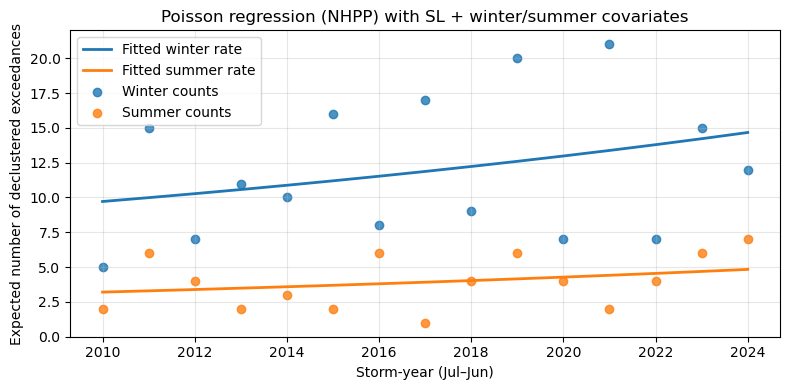

In [76]:
# CELL – PyMC Poisson regression (NHPP-style) with sea level + winter/summer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc as pm
try:
    import pytensor.tensor as pt
except ImportError:
    import aesara.tensor as pt

import arviz as az

# -----------------------------------------------------------
# 1. Build winter / summer counts from declustered events
#    Assumes `clusters` from runs-declustering is in memory and has `max_time`.
# -----------------------------------------------------------

def storm_year(ts):
    """Jul–Jun storm-year."""
    y = ts.year
    return y if ts.month >= 7 else y - 1

def season_label(ts):
    """Winter: Oct–Mar, Summer: Apr–Sep."""
    m = ts.month
    return "winter" if m in (10, 11, 12, 1, 2, 3) else "summer"

clusters = clusters.copy()
clusters["storm_year"] = clusters["max_time"].apply(storm_year)
clusters["season"] = clusters["max_time"].apply(season_label)
clusters["is_winter"] = (clusters["season"] == "winter").astype(int)

season_counts = (
    clusters
    .groupby(["storm_year", "season", "is_winter"])
    .size()
    .reset_index(name="count")
)

print("Seasonal counts of declustered exceedances:")
print(season_counts.head())

# -----------------------------------------------------------
# 2. Load annual sea-level ensemble and build covariate
# -----------------------------------------------------------

data = np.load("data/varberg_sl_annual_2010_2200.npz")
years_sl = data["years"]          # shape (N_years,)
sl_samples = data["sl"]           # shape (N_paths, N_years)
sl_mean = sl_samples.mean(axis=0) # ensemble-mean SL per year

sl_df = pd.DataFrame({"storm_year": years_sl, "sl_mean": sl_mean})

# Merge SL covariate with seasonal counts
df = pd.merge(season_counts, sl_df, on="storm_year", how="inner")
df = df.sort_values(["storm_year", "season"]).reset_index(drop=True)

# Center sea level for stability
df["sl_c"] = df["sl_mean"] - df["sl_mean"].mean()

print("\nData for Poisson regression (first rows):")
print(df.head())

y = df["count"].values.astype("int32")
sl_c = df["sl_c"].values
winter = df["is_winter"].values.astype("int32")

n_obs = len(df)

# -----------------------------------------------------------
# 3. Homogeneous Poisson model (null model)
# -----------------------------------------------------------

with pm.Model() as pois_hom:
    alpha = pm.Normal("alpha", mu=np.log(y.mean() + 1e-3), sigma=2.0)
    log_lambda = alpha
    lam = pm.Deterministic("lambda", pt.exp(log_lambda))
    counts = pm.Poisson("counts", mu=lam, observed=y)

    idata_hom = pm.sample(
        500,
        tune=200,
        target_accept=0.9,
        cores=14,
        chains=14,
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},  # <-- store loglik for observed vars
    )
    waic_hom = az.waic(idata_hom)

print("\nHomogeneous Poisson WAIC:")
print(waic_hom)

# -----------------------------------------------------------
# 4. NHPP-style model: log λ = α + β_sl * sl_c + β_w * winter
# -----------------------------------------------------------

with pm.Model() as pois_nhpp:
    alpha = pm.Normal("alpha", mu=0.0, sigma=5.0)
    beta_sl = pm.Normal("beta_sl", mu=0.0, sigma=2.0)
    beta_w = pm.Normal("beta_w", mu=0.0, sigma=2.0)

    log_lambda = alpha + beta_sl * sl_c + beta_w * winter
    lam = pm.Deterministic("lambda", pt.exp(log_lambda))

    counts = pm.Poisson("counts", mu=lam, observed=y)

    idata_nhpp = pm.sample(
        500,
        tune=200,
        target_accept=0.9,
        cores=14,
        chains=14,
        random_seed=43,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},  # <-- same here
    )
    waic_nhpp = az.waic(idata_nhpp)

print("\nNHPP (SL + winter) WAIC:")
print(waic_nhpp)

print("\nWAIC comparison (lower is better):")
print(az.compare({"hom": idata_hom, "nhpp": idata_nhpp}, ic="waic"))

# -----------------------------------------------------------
# 5. Posterior mean rates and plot
# -----------------------------------------------------------

# Posterior mean lambda per observation for NHPP model
lam_post = idata_nhpp.posterior["lambda"]    # dims: chain, draw, obs
lam_mean = lam_post.mean(dim=("chain", "draw")).values  # shape (n_obs,)

df["lambda_mean"] = lam_mean

# Split by winter / summer
winter_mask = df["is_winter"] == 1
summer_mask = df["is_winter"] == 0

winter_df = df[winter_mask].set_index("storm_year")
summer_df = df[summer_mask].set_index("storm_year")

plt.figure(figsize=(8, 4))

# Fitted rates
plt.plot(
    winter_df.index,
    winter_df["lambda_mean"],
    label="Fitted winter rate",
    linewidth=2,
)
plt.plot(
    summer_df.index,
    summer_df["lambda_mean"],
    label="Fitted summer rate",
    linewidth=2,
)

# Observed counts (points)
plt.scatter(
    winter_df.index,
    winter_df["count"],
    color="C0",
    alpha=0.8,
    label="Winter counts",
)
plt.scatter(
    summer_df.index,
    summer_df["count"],
    color="C1",
    alpha=0.8,
    label="Summer counts",
)

plt.xlabel("Storm-year (Jul–Jun)")
plt.ylabel("Expected number of declustered exceedances")
plt.title("Poisson regression (NHPP) with SL + winter/summer covariates")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



Posterior summary for NHPP coefficients:
          mean     sd  hdi_3%  hdi_97%
alpha    1.356  0.129   1.111    1.597
beta_sl  0.014  0.007   0.000    0.026
beta_w   1.115  0.147   0.859    1.419

LOO comparison (higher elpd_loo is better):
      rank    elpd_loo     p_loo  elpd_diff    weight         se        dse  \
nhpp     0  -78.860714  4.106826   0.000000  0.940364   4.765317   0.000000   
hom      1 -111.521642  3.578695  32.660928  0.059636  11.353838  10.013594   

      warning scale  
nhpp    False   log  
hom     False   log  


<Figure size 600x350 with 0 Axes>

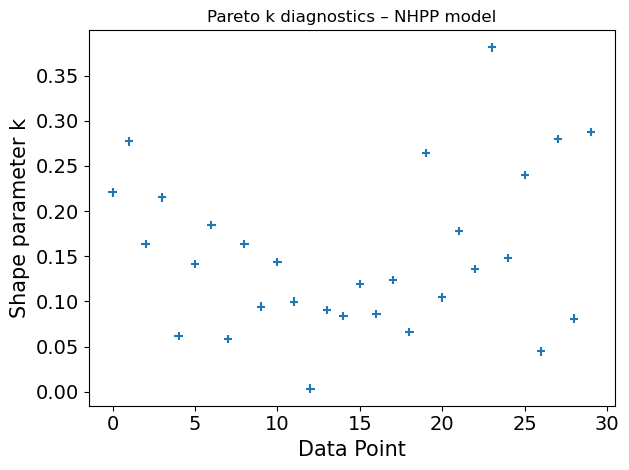

Sampling: [counts]


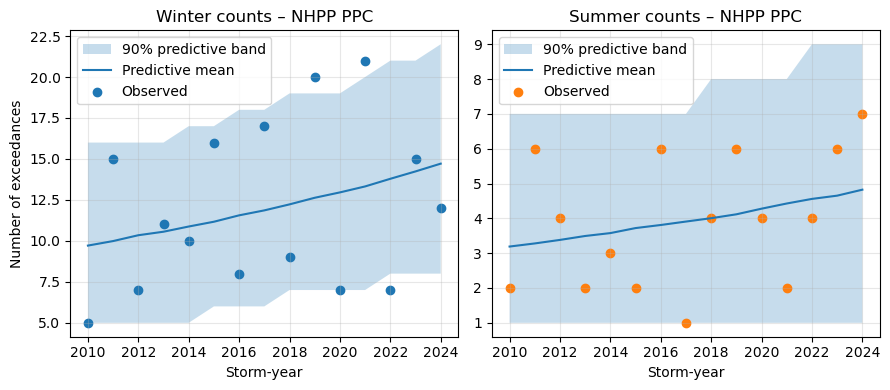

In [79]:
# CELL – Extra diagnostics for NHPP Poisson model (PyMC + ArviZ)

import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

# 1. Posterior summary for regression coefficients
print("Posterior summary for NHPP coefficients:")
print(
    az.summary(
        idata_nhpp,
        var_names=["alpha", "beta_sl", "beta_w"],
        kind="stats",
        round_to=3,
    )
)

# 2. LOO and model comparison
loo_hom = az.loo(idata_hom, pointwise=True)
loo_nhpp = az.loo(idata_nhpp, pointwise=True)

print("\nLOO comparison (higher elpd_loo is better):")
print(az.compare({"hom": idata_hom, "nhpp": idata_nhpp}, ic="loo"))

# Pareto-k diagnostics for NHPP (this explains WAIC/LOO warnings)
plt.figure(figsize=(6, 3.5))
az.plot_khat(loo_nhpp)
plt.title("Pareto k diagnostics – NHPP model")
plt.tight_layout()
plt.show()

# 3. Posterior predictive check for counts (NHPP)

with pois_nhpp:
    ppc_idata = pm.sample_posterior_predictive(
        idata_nhpp,
        var_names=["counts"],
        random_seed=123,
        progressbar=False,
        return_inferencedata=True,
    )

# counts array: dims (chain, draw, obs)
counts_ppc = ppc_idata.posterior_predictive["counts"].values
# reshape to (n_draws, n_obs)
counts_ppc = counts_ppc.reshape(-1, counts_ppc.shape[-1])

mean_ppc = counts_ppc.mean(axis=0)
low_ppc = np.quantile(counts_ppc, 0.05, axis=0)
high_ppc = np.quantile(counts_ppc, 0.95, axis=0)

df_ppc = df.copy()
df_ppc["count_pred_mean"] = mean_ppc
df_ppc["count_pred_low"] = low_ppc
df_ppc["count_pred_high"] = high_ppc

# Split by winter / summer
winter_mask = df_ppc["is_winter"] == 1
summer_mask = df_ppc["is_winter"] == 0

winter_df = df_ppc[winter_mask].set_index("storm_year")
summer_df = df_ppc[summer_mask].set_index("storm_year")

plt.figure(figsize=(9, 4))

# Winter PPC
plt.subplot(1, 2, 1)
plt.fill_between(
    winter_df.index,
    winter_df["count_pred_low"],
    winter_df["count_pred_high"],
    alpha=0.25,
    label="90% predictive band",
)
plt.plot(
    winter_df.index,
    winter_df["count_pred_mean"],
    label="Predictive mean",
)
plt.scatter(
    winter_df.index,
    winter_df["count"],
    color="C0",
    label="Observed",
)
plt.title("Winter counts – NHPP PPC")
plt.xlabel("Storm-year")
plt.ylabel("Number of exceedances")
plt.grid(True, alpha=0.3)
plt.legend()

# Summer PPC
plt.subplot(1, 2, 2)
plt.fill_between(
    summer_df.index,
    summer_df["count_pred_low"],
    summer_df["count_pred_high"],
    alpha=0.25,
    label="90% predictive band",
)
plt.plot(
    summer_df.index,
    summer_df["count_pred_mean"],
    label="Predictive mean",
)
plt.scatter(
    summer_df.index,
    summer_df["count"],
    color="C1",
    label="Observed",
)
plt.title("Summer counts – NHPP PPC")
plt.xlabel("Storm-year")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [alpha, beta_sl]


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 14 chains for 800 tune and 2_000 draw iterations (11_200 + 28_000 draws total) took 186 seconds.



=== MSL-only model diagnostics ===
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha    2.063  0.065   1.943    2.187        0.0      0.0  24086.764   
beta_sl  0.014  0.007   0.001    0.027        0.0      0.0  25725.081   

          ess_tail  r_hat  
alpha    19031.200    1.0  
beta_sl  18953.098    1.0  


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(



MSL-only WAIC:
Computed from 28000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -111.57    10.81
p_waic        6.32        -

There has been a warning during the calculation. Please check the results.

MSL-only LOO:
Computed from 28000 posterior samples and 30 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -111.61    10.81
p_loo        6.36        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       30  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [alpha, beta_sl, beta_w]


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 14 chains for 800 tune and 2_000 draw iterations (11_200 + 28_000 draws total) took 189 seconds.



=== MSL + season model diagnostics ===
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha    1.355  0.130   1.107    1.596      0.001    0.001  10499.689   
beta_sl  0.014  0.007   0.001    0.027      0.000    0.000  15736.910   
beta_w   1.115  0.149   0.835    1.394      0.001    0.001  10625.033   

          ess_tail  r_hat  
alpha    12588.752  1.001  
beta_sl  15117.681  1.001  
beta_w   12885.510  1.001  


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(



MSL + season WAIC:
Computed from 28000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -78.87     4.76
p_waic        4.12        -

There has been a warning during the calculation. Please check the results.

MSL + season LOO:
Computed from 28000 posterior samples and 30 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -78.94     4.78
p_loo        4.19        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       30  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


=== WAIC comparison (lower is better) ===
            rank   elpd_waic    p_waic  elpd_diff    weight         se  \
msl_season     0  -78.874595  4.120477   0.000000  0.956825   4.762982   
msl_only       1 -111.572896  6.319756  32.698301  0.043175  10.806538   

                 dse  warning scale  
msl_season  0.000000     True   log  
msl_only    9.382296   

c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


            rank    elpd_loo     p_loo  elpd_diff    weight         se  \
msl_season     0  -78.943586  4.189468    0.00000  0.955082   4.775894   
msl_only       1 -111.609945  6.356805   32.66636  0.044918  10.812220   

                 dse  warning scale  
msl_season  0.000000    False   log  
msl_only    9.390456    False   log  

Pareto-k diagnostics for MSL + season model:


<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

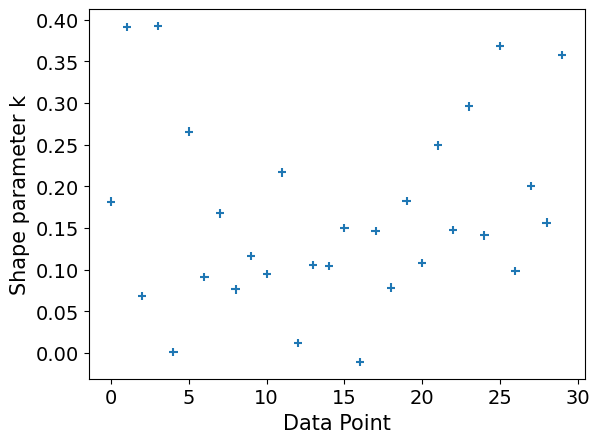

In [80]:
# CELL – Poisson models: MSL-only vs MSL + season, with diagnostics & comparison

import numpy as np
import arviz as az
import pymc as pm
try:
    import pytensor.tensor as pt
except ImportError:
    import aesara.tensor as pt

# Response and covariates from your existing df
y = df["count"].values.astype("int32")
sl_c = df["sl_c"].values
winter = df["is_winter"].values.astype("int32")
n_obs = len(df)

# -----------------------------------------------------------
# 1. MSL-only model: log λ = α + β_sl * sl_c
# -----------------------------------------------------------

with pm.Model() as pois_msl:
    alpha = pm.Normal("alpha", mu=0.0, sigma=5.0)
    beta_sl = pm.Normal("beta_sl", mu=0.0, sigma=2.0)

    log_lambda = alpha + beta_sl * sl_c
    lam = pm.Deterministic("lambda", pt.exp(log_lambda))

    counts = pm.Poisson("counts", mu=lam, observed=y)

    idata_msl = pm.sample(
        draws=2000,          # 4× previous 500
        tune=800,            # 4× previous 200
        target_accept=0.9,
        chains=14,
        cores=14,
        random_seed=101,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
    )

# Diagnostics for MSL-only model
print("\n=== MSL-only model diagnostics ===")
print(
    az.summary(
        idata_msl,
        var_names=["alpha", "beta_sl"],
        round_to=3,
    )
)

waic_msl = az.waic(idata_msl)
loo_msl = az.loo(idata_msl)
print("\nMSL-only WAIC:")
print(waic_msl)
print("\nMSL-only LOO:")
print(loo_msl)

# -----------------------------------------------------------
# 2. MSL + season model: log λ = α + β_sl * sl_c + β_w * winter
# -----------------------------------------------------------

with pm.Model() as pois_msl_season:
    alpha = pm.Normal("alpha", mu=0.0, sigma=5.0)
    beta_sl = pm.Normal("beta_sl", mu=0.0, sigma=2.0)
    beta_w = pm.Normal("beta_w", mu=0.0, sigma=2.0)

    log_lambda = alpha + beta_sl * sl_c + beta_w * winter
    lam = pm.Deterministic("lambda", pt.exp(log_lambda))

    counts = pm.Poisson("counts", mu=lam, observed=y)

    idata_msl_season = pm.sample(
        draws=2000,
        tune=800,
        target_accept=0.9,
        chains=14,
        cores=14,
        random_seed=202,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
    )

# Diagnostics for MSL + season model
print("\n=== MSL + season model diagnostics ===")
print(
    az.summary(
        idata_msl_season,
        var_names=["alpha", "beta_sl", "beta_w"],
        round_to=3,
    )
)

waic_msl_season = az.waic(idata_msl_season)
loo_msl_season = az.loo(idata_msl_season)
print("\nMSL + season WAIC:")
print(waic_msl_season)
print("\nMSL + season LOO:")
print(loo_msl_season)

# -----------------------------------------------------------
# 3. Model comparison: MSL-only vs MSL + season
# -----------------------------------------------------------

print("\n=== WAIC comparison (lower is better) ===")
print(
    az.compare(
        {"msl_only": idata_msl, "msl_season": idata_msl_season},
        ic="waic",
    )
)

print("\n=== LOO comparison (higher elpd_loo is better) ===")
print(
    az.compare(
        {"msl_only": idata_msl, "msl_season": idata_msl_season},
        ic="loo",
    )
)

# Optional: Pareto-k diagnostics for the preferred model (likely msl_season)
print("\nPareto-k diagnostics for MSL + season model:")
loo_msl_season_pw = az.loo(idata_msl_season, pointwise=True)
az.plot_khat(loo_msl_season_pw)


## Latent-covariate Poisson–GPD point-process model

We now construct a peaks-over-threshold (POT) / point-process analogue of the latent-covariate GEV model. The idea is:

- Use **declustered POT events** (storm maxima above a high threshold $u$),
- Model their **occurrence in time** as a Poisson process with rate depending on mean sea level (MSL),
- Model their **magnitudes** with a GPD that does *not* depend on MSL,
- And use the AR6 ensemble as a **prior over latent MSL paths**, just as in the GEV mixture model.

### 1. Declustered POT data

Fix a high threshold $u$ (e.g. $u = 60$ cm) and apply runs declustering (e.g. run length 24h) to the sub-daily sea-level series. This gives a sequence of storm events with cluster maxima
$$
Y_{t,i}, \quad i = 1, \dots, N_t, \quad t = t_0, \dots, t_T,
$$
where $t$ indexes storm-years (Jul–Jun) and $N_t$ is the number of declustered exceedances in storm-year $t$.

Define the **excesses** over $u$ by
$$
Z_{t,i} = Y_{t,i} - u > 0.
$$

The data consist of the yearly counts $N_t$ and the excesses $\{Z_{t,i}\}$, together with the corresponding storm-year indices.

---

### 2. Latent MSL path $X_t$ from AR6

As in the block-maxima GEV model, we use the AR6 Varberg ensemble as a prior for the latent mean sea level $X_t$ (in cm) for each storm-year $t$:
$$
X_{t_0:T} \sim p_{\mathrm{AR6}}(X_{t_0:T}),
$$
where $p_{\mathrm{AR6}}$ is approximated by the empirical distribution of AR6 sample paths.

Concretely, we have an array
$$
X^{(m)}_t, \quad m = 1,\dots,M,\quad t = t_0,\dots,t_T,
$$
stored as `X_block_prior_cm[m, year_index]`, representing $M$ AR6 MSL paths in cm. We treat these as $M$ draws from the prior $p_{\mathrm{AR6}}$ and approximate integrals over $X_{t_0:T}$ by finite mixtures over $m$.

---

### 3. Conditional Poisson–GPD model given $X_t$

Conditional on a particular AR6 path $m$, we assume:

1. **Occurrence model (intensity depends on MSL)**  

   The number of declustered extremes in storm-year $t$ follows
   $$
   N_t \mid X_t^{(m)}, \eta
   \sim \mathrm{Poisson}\bigl(\Lambda_t^{(m)}\bigr), \qquad
   \log \Lambda_t^{(m)} = \eta_0 + \eta_1 X_t^{(m)}.
   $$
   Here $\Lambda_t^{(m)}$ is the expected number of POT events in year $t$ under AR6 path $m$, and MSL affects only the **intensity** via a log-linear link.

2. **Magnitude model (GPD tail, independent of MSL)**  

   Conditional on $N_t$ and $X_t^{(m)}$, the excesses over $u$ are i.i.d.
   $$
   Z_{t,i} \mid X_t^{(m)}, \theta \sim \mathrm{GPD}(\sigma, \xi),
   $$
   with scale $\sigma > 0$ and shape $\xi$ constant over time and independent of MSL. The GPD density for $z > 0$ is
   $$
   f_{\mathrm{GPD}}(z \mid \sigma, \xi)
   = \frac{1}{\sigma} \left( 1 + \xi \frac{z}{\sigma} \right)^{-1/\xi - 1},
   \quad 1 + \xi \frac{z}{\sigma} > 0.
   $$

Given a path $m$, the likelihood factorizes as
$$
p(\{N_t, Z_{t,i}\} \mid X^{(m)}, \eta, \sigma, \xi)
= \prod_t \mathrm{Poisson}\bigl(N_t \mid \Lambda_t^{(m)}\bigr)
  \cdot \prod_{t,i} f_{\mathrm{GPD}}(Z_{t,i} \mid \sigma, \xi).
$$

Note that MSL affects only the occurrence rate $\Lambda_t^{(m)}$, not the tail parameters $(\sigma,\xi)$.

---

### 4. Marginal likelihood via AR6 mixture

We do not observe $X_t$ or the path index $m$. Instead, we integrate (average) over the AR6 ensemble:
$$
p(\{N_t, Z_{t,i}\} \mid \eta, \sigma, \xi)
= \int p(\{N_t, Z_{t,i}\} \mid X, \eta, \sigma, \xi)\, p_{\mathrm{AR6}}(X)\, dX.
$$

Since $p_{\mathrm{AR6}}$ is approximated by the empirical distribution of the $M$ AR6 paths, we approximate this integral as a finite mixture:
$$
p(\{N_t, Z_{t,i}\} \mid \eta, \sigma, \xi)
\approx \frac{1}{M} \sum_{m=1}^M
\prod_t \mathrm{Poisson}\bigl(N_t \mid \Lambda_t^{(m)}\bigr)
\cdot \prod_{t,i} f_{\mathrm{GPD}}(Z_{t,i} \mid \sigma, \xi).
$$

Because the GPD part does not depend on $m$, this simplifies to
$$
p(\{N_t, Z_{t,i}\} \mid \eta, \sigma, \xi)
\approx
\left[ \prod_{t,i} f_{\mathrm{GPD}}(Z_{t,i} \mid \sigma, \xi) \right]
\cdot
\prod_t \left[ \frac{1}{M} \sum_{m=1}^M
\mathrm{Poisson}\bigl(N_t \mid \Lambda_t^{(m)}\bigr) \right].
$$

The log-likelihood (up to a constant not depending on parameters) is
$$
\ell(\eta, \sigma, \xi)
\approx
\sum_{t,i} \log f_{\mathrm{GPD}}(Z_{t,i} \mid \sigma, \xi)
+ \sum_t \log \left[
\frac{1}{M} \sum_{m=1}^M
\exp\bigl(\log \mathrm{Poisson}\bigl(N_t \mid \Lambda_t^{(m)}\bigr)\bigr)
\right].
$$

We evaluate the second term with a numerically stable log-sum-exp over AR6 paths, exactly as in the GEV mixture model.

---

### 5. From Poisson–GPD to annual maximum

Given parameters $(\eta_0,\eta_1,\sigma,\xi)$ and a particular MSL value $X_t$ in a year, the annual maximum $M_t$ over the threshold $u$ has cdf
$$
\Pr(M_t \le y \mid X_t) =
\exp\left\{ -\Lambda_t(X_t) \left[ 1 + \xi \frac{y - u}{\sigma} \right]^{-1/\xi} \right\},
\qquad y \ge u,
$$
with $\Lambda_t(X_t) = \exp(\eta_0 + \eta_1 X_t)$.

Thus, once the model is fitted, we can use posterior draws of $(\eta_0,\eta_1,\sigma,\xi)$ together with AR6 MSL paths $X_t^{(m)}$ to derive the posterior distribution of the **highest flooding event per year**, in exactly the same way the latent-covariate GEV model does, but via the point-process route.


In [2]:
# CELL 0 – Imports and data loading for PP + GEV models (run this after restart)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc as pm
try:
    import pytensor.tensor as pt
except ImportError:
    import aesara.tensor as pt

import arviz as az

# -----------------------------------
# 1. Load Halmstad sea-level data
# -----------------------------------

file_path = "data/HALMSTAD SJÖV - RH 2000.csv"

df_full = pd.read_csv(file_path, sep=";", encoding="utf-8")
df_full["datetime"] = pd.to_datetime(df_full["Datum Tid (UTC)"])
df_full = df_full.set_index("datetime")

df_full = df_full[["Havsvattenstånd"]].copy()
df_full = df_full.rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to a broad window
df_full = df_full.loc["2009-01-01":"2025-12-31"]

# Storm-year (Jul–Jun) helper
def storm_year(ts):
    y = ts.year
    return y if ts.month >= 7 else y - 1

# Work series for both block maxima and POT
series = df_full["sea_level_cm"].loc["2009-07-01":"2025-06-30"].dropna()

# Block maxima by storm-year
storm_year_index = series.index.to_series().apply(storm_year)
block_max = series.groupby(storm_year_index).max()   # index: storm_year

print("Storm-year block maxima (first few):")
print(block_max.head())

# -----------------------------------
# 2. Load AR6 Varberg MSL ensemble and align with block maxima
# -----------------------------------

# File must contain:
#   years: shape (N_years,)
#   sl:    shape (N_paths, N_years)
sl_data = np.load("data/varberg_sl_annual_2010_2200.npz")
years_sl = sl_data["years"]              # (N_years,)
sl_samples = sl_data["sl"].astype(float) # (N_paths, N_years)

# Intersect storm-year labels with AR6 years to avoid KeyError (e.g. 2009 not in years_sl)
storm_years_block_all = block_max.index.values.astype(int)
storm_years_block = np.intersect1d(storm_years_block_all, years_sl.astype(int))

if len(storm_years_block) == 0:
    raise ValueError("No overlap between storm-year block maxima and AR6 years!")

# Align Y_obs_cm with this intersection
Y_obs_cm = block_max.loc[storm_years_block].values.astype(float)  # (K,)

# Build X_block_prior_cm (M, K) using matching AR6 years
year_to_idx_sl = {int(y): i for i, y in enumerate(years_sl)}
idxs = np.array([year_to_idx_sl[int(y)] for y in storm_years_block], dtype=int)

X_block_prior_cm = sl_samples[:, idxs]   # (M, K)
M, K = X_block_prior_cm.shape

print("\nAligned years (storm_years_block):", storm_years_block)
print("Y_obs_cm shape:", Y_obs_cm.shape)
print("X_block_prior_cm shape:", X_block_prior_cm.shape)

# -----------------------------------
# 3. Build declustered POT events (clusters) for threshold u
# -----------------------------------

u = 60.0      # POT threshold in cm
run_hours = 24.0  # runs declustering gap in hours

def runs_declustering(ts, values, u, run_hours=24.0):
    """
    Simple runs declustering:
      - ts: DatetimeIndex
      - values: array of sea levels (same length as ts)
      - u: threshold in cm
      - run_hours: minimum gap between clusters (in hours)
    Returns a DataFrame 'clusters' with one row per cluster maximum.
    """
    df = pd.DataFrame({"time": ts, "value": values})
    df = df.sort_values("time")
    exceed = df[df["value"] > u].copy()
    if exceed.empty:
        return pd.DataFrame(columns=["cluster_id", "start_time", "end_time", "max_time", "max_level", "storm_year"])

    exceed["gap_hours"] = exceed["time"].diff().dt.total_seconds().div(3600.0)
    new_cluster = (exceed["gap_hours"].isna()) | (exceed["gap_hours"] >= run_hours)
    exceed["cluster_id"] = new_cluster.cumsum()

    clusters_list = []
    for cid, grp in exceed.groupby("cluster_id"):
        start_time = grp["time"].min()
        end_time = grp["time"].max()
        max_row = grp.loc[grp["value"].idxmax()]
        max_time = max_row["time"]
        max_level = max_row["value"]
        sy = storm_year(max_time)
        clusters_list.append(
            {
                "cluster_id": int(cid),
                "start_time": start_time,
                "end_time": end_time,
                "max_time": max_time,
                "max_level": float(max_level),
                "storm_year": int(sy),
            }
        )
    return pd.DataFrame(clusters_list)

clusters = runs_declustering(series.index, series.values, u=u, run_hours=run_hours)

print("\nNumber of declustered clusters above u:", len(clusters))
print(clusters.head())



Storm-year block maxima (first few):
datetime
2009    137.4
2010     85.6
2011    135.4
2012     89.1
2013    172.2
Name: sea_level_cm, dtype: float64

Aligned years (storm_years_block): [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024]
Y_obs_cm shape: (15,)
X_block_prior_cm shape: (20000, 15)

Number of declustered clusters above u: 249
   cluster_id          start_time            end_time            max_time  \
0           1 2009-09-05 18:00:00 2009-09-05 23:00:00 2009-09-05 20:00:00   
1           2 2009-09-28 16:00:00 2009-09-28 16:00:00 2009-09-28 16:00:00   
2           3 2009-10-03 17:00:00 2009-10-05 09:00:00 2009-10-04 18:00:00   
3           4 2009-10-07 10:00:00 2009-10-07 13:00:00 2009-10-07 11:00:00   
4           5 2009-10-08 20:00:00 2009-10-09 00:00:00 2009-10-08 21:00:00   

   max_level  storm_year  
0       69.6        2009  
1       60.8        2009  
2      137.4        2009  
3       66.6        2009  
4       84.1        2009  


In [3]:
# CELL PP-1 – Prepare POT counts/excesses and align with AR6 prior paths

import numpy as np
import pandas as pd

# --- Inputs assumed available ---
# clusters: DataFrame with declustered storm events
#   columns: ["storm_year", "max_time", "max_level", ...]
# X_block_prior_cm: array (M, K) of AR6 MSL paths in cm (same time span as Y_obs_cm)
# Y_obs_cm: array (K,) of storm-year block maxima in cm
# u: threshold in cm, e.g. u = 60.0
u = 60
# 1. Shapes and basic checks
X_prior_np = X_block_prior_cm.astype(float)
M, K = X_prior_np.shape
assert K == Y_obs_cm.shape[0], "X_block_prior_cm columns must match Y_obs_cm length"

# 2. Define the storm-year labels corresponding to the K columns
#    Here we infer them from the declustered data: take the K most recent storm-years
#    present in `clusters`, sorted, and assume they correspond to the columns of X_block_prior_cm.
storm_years_all = np.sort(clusters["storm_year"].unique())
assert len(storm_years_all) >= K, "Not enough storm-years in clusters to match AR6 prior"

storm_years_block = storm_years_all[-K:]  # use the last K storm-years
print("storm_years_block:", storm_years_block)

# 3. Filter clusters to those years
clusters_pp = clusters[clusters["storm_year"].isin(storm_years_block)].copy()

# 4. Keep only events above threshold u and compute excess
clusters_pp = clusters_pp[clusters_pp["max_level"] > u].copy()
clusters_pp["excess"] = clusters_pp["max_level"] - u

# 5. Map storm_year -> year index (0..K-1), consistent with storm_years_block order
year_to_idx = {y: i for i, y in enumerate(storm_years_block)}
clusters_pp["year_idx"] = clusters_pp["storm_year"].map(year_to_idx).astype(int)

# 6. Yearly counts N_t (in the order of storm_years_block)
N_t = (
    clusters_pp
    .groupby("storm_year")
    .size()
    .reindex(storm_years_block, fill_value=0)
    .values.astype(int)
)

# 7. Excess vector for GPD (all years pooled, since GPD params are constant)
excesses_np = clusters_pp["excess"].values.astype(float)

print(f"Number of AR6 paths M = {M}")
print(f"Number of years K    = {K}")
print(f"Number of declustered events above u = {len(excesses_np)}")
print("First few (year, N_t):", list(zip(storm_years_block[:5], N_t[:5])))


storm_years_block: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024]
Number of AR6 paths M = 20000
Number of years K    = 15
Number of declustered events above u = 239
First few (year, N_t): [(np.int64(2010), np.int64(7)), (np.int64(2011), np.int64(21)), (np.int64(2012), np.int64(11)), (np.int64(2013), np.int64(13)), (np.int64(2014), np.int64(13))]


In [4]:
# CELL PP-2 – Poisson–GPD AR6-mixture model with intensity depending on MSL

import pymc as pm
try:
    import pytensor.tensor as pt
except ImportError:
    import aesara.tensor as pt
import arviz as az
import numpy as np

# Backend tensors
N_t_const      = pt.as_tensor_variable(N_t.astype("int32"))   # shape (K,)
X_prior_const  = pt.as_tensor_variable(X_prior_np)            # shape (M, K)
excesses_const = pt.as_tensor_variable(excesses_np)           # shape (n_events,)

def gpd_logpdf(e, sigma, xi):
    """
    Log-density of GPD(e | sigma, xi) for excess e >= 0:

        f(e) = 1/sigma * (1 + xi * e / sigma)^(-1/xi - 1)

    Works elementwise; e, sigma, xi can broadcast.
    """
    e = pt.as_tensor_variable(e)
    sigma = pt.as_tensor_variable(sigma)
    xi = pt.as_tensor_variable(xi)

    z = 1.0 + xi * e / sigma
    log_sigma = pt.log(sigma)
    inv_xi = 1.0 / xi

    logp = -log_sigma - (inv_xi + 1.0) * pt.log(z)
    logp = pt.switch(z <= 0.0, -np.inf, logp)
    return logp

with pm.Model() as pp_mixture_model:
    # --- Occurrence part: N_t ~ mixture over AR6 paths of Poisson(Λ_t^{(m)}) ---

    # Priors on intensity regression coefficients
    # Λ_t^{(m)} = exp(eta0 + eta1 * X_t^{(m)}), with X_t^{(m)} in cm
    N_mean = float(N_t.mean() + 1e-3)
    eta0 = pm.Normal("eta0", mu=np.log(N_mean), sigma=2.0)
    eta1 = pm.Normal("eta1", mu=0.0, sigma=2.0)

    # Λ_mt: shape (M, K)
    log_Lambda_mt = eta0 + eta1 * X_prior_const
    Lambda_mt = pt.exp(log_Lambda_mt)

    # Broadcast counts to (M, K): same N_t across all paths m
    N_mat = N_t_const[None, :]  # shape (1, K) -> broadcasts to (M, K)

    # Poisson log-density for each (m, t), up to a constant (drop log n! term)
    logf_occ_mt = N_mat * pt.log(Lambda_mt) - Lambda_mt  # shape (M, K)

    # For each t, mixture over m: p(N_t | η) ≈ (1/M) Σ_m f_occ_mt(m,t)
    # Compute log p(N_t | η) via log-sum-exp over m
    max_logf_occ = pt.max(logf_occ_mt, axis=0, keepdims=True)        # (1, K)
    stable_sum_occ = pt.sum(pt.exp(logf_occ_mt - max_logf_occ), axis=0)  # (K,)
    logsumexp_occ = pt.flatten(max_logf_occ) + pt.log(stable_sum_occ)    # (K,)

    # log (1/M Σ_m f_occ) = logsumexp - log(M)
    log_mix_occ_t = logsumexp_occ - pt.log(np.array(float(M)))

    # Total occurrence log-likelihood over years
    loglik_occ = pt.sum(log_mix_occ_t)

    # --- GPD magnitude part: excesses ~ GPD(σ, ξ), independent of X ---

    exc_mean = float(excesses_np.mean())
    alpha0 = pm.Normal("alpha0", mu=np.log(max(exc_mean, 1.0)), sigma=2.0)
    sigma = pt.exp(alpha0)
    xi = pm.Normal("xi", mu=0., sigma=2)

    logf_gpd = gpd_logpdf(excesses_const, sigma, xi)
    loglik_gpd = pt.sum(logf_gpd)

    # --- Total log-likelihood as a Potential ---
    pm.Potential("pp_loglik", loglik_occ + loglik_gpd)

    # --- Sample posterior ---
    idata_pp = pm.sample(
        draws=1600,
        tune=400,
        target_accept=0.9,
        chains=4,
        cores=4,
        random_seed=123,
        return_inferencedata=True,
    )

# Basic diagnostics
print(
    az.summary(
        idata_pp,
        var_names=["eta0", "eta1", "alpha0", "xi"],
        round_to=3,
    )
)

c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta0, eta1, alpha0, xi]


KeyboardInterrupt: 

In [27]:
# CELL PP-2 – Poisson–GPD AR6-mixture model with intensity depending on MSL
#                using a fixed subsample of up to 1000 AR6 paths

import pymc as pm
try:
    import pytensor.tensor as pt
except ImportError:
    import aesara.tensor as pt
import arviz as az
import numpy as np

# --- Subsample AR6 paths to M_sub = min(1000, M_full) ---

M_full, K = X_prior_np.shape
M_sub = min(14000, M_full)
print(M_sub)
rng = np.random.default_rng(123)  # fixed seed for reproducible subset
sub_idx = rng.choice(M_full, size=M_sub, replace=False)

X_prior_sub = X_prior_np[sub_idx, :].astype(float)  # shape (M_sub, K)
M = M_sub  # from here on, M is the subsampled number of paths

# Backend tensors
N_t_const      = pt.as_tensor_variable(N_t.astype("int32"))   # shape (K,)
X_prior_const  = pt.as_tensor_variable(X_prior_sub)           # shape (M, K)
excesses_const = pt.as_tensor_variable(excesses_np)           # shape (n_events,)

def gpd_logpdf(e, sigma, xi):
    """
    Log-density of GPD(e | sigma, xi) for excess e >= 0:

        f(e) = 1/sigma * (1 + xi * e / sigma)^(-1/xi - 1)

    Works elementwise; e, sigma, xi can broadcast.
    """
    e = pt.as_tensor_variable(e)
    sigma = pt.as_tensor_variable(sigma)
    xi = pt.as_tensor_variable(xi)

    z = 1.0 + xi * e / sigma
    log_sigma = pt.log(sigma)
    inv_xi = 1.0 / xi

    logp = -log_sigma - (inv_xi + 1.0) * pt.log(z)
    logp = pt.switch(z <= 0.0, -np.inf, logp)
    return logp

with pm.Model() as pp_mixture_model:
    # --- Occurrence part: N_t ~ mixture over AR6 paths of Poisson(Λ_t^{(m)}) ---

    # Priors on intensity regression coefficients
    # Λ_t^{(m)} = exp(eta0 + eta1 * X_t^{(m)}), with X_t^{(m)} in cm
    N_mean = float(N_t.mean() + 1e-3)
    eta0 = pm.Normal("eta0", mu=np.log(N_mean), sigma=2.0)
    eta1 = pm.Normal("eta1", mu=0.0, sigma=2.0)

    # Λ_mt: shape (M, K) for subsampled paths
    log_Lambda_mt = eta0 + eta1 * X_prior_const
    Lambda_mt = pt.exp(log_Lambda_mt)

    # Broadcast counts to (M, K): same N_t across all paths m
    N_mat = N_t_const[None, :]  # shape (1, K) -> broadcasts to (M, K)

    # Poisson log-density for each (m, t), up to a constant (drop log n! term)
    logf_occ_mt = N_mat * pt.log(Lambda_mt) - Lambda_mt  # shape (M, K)

    # For each t, mixture over m: p(N_t | η) ≈ (1/M) Σ_m f_occ_mt(m,t)
    # Compute log p(N_t | η) via log-sum-exp over m
    max_logf_occ = pt.max(logf_occ_mt, axis=0, keepdims=True)            # (1, K)
    stable_sum_occ = pt.sum(pt.exp(logf_occ_mt - max_logf_occ), axis=0)  # (K,)
    logsumexp_occ = pt.flatten(max_logf_occ) + pt.log(stable_sum_occ)    # (K,)

    # log (1/M Σ_m f_occ) = logsumexp - log(M)
    log_mix_occ_t = logsumexp_occ - pt.log(np.array(float(M)))

    # Total occurrence log-likelihood over years
    loglik_occ = pt.sum(log_mix_occ_t)

    # --- GPD magnitude part: excesses ~ GPD(σ, ξ), independent of X ---

    exc_mean = float(excesses_np.mean())
    alpha0 = pm.Normal("alpha0", mu=np.log(max(exc_mean, 1.0)), sigma=2.0)
    sigma = pt.exp(alpha0)
    xi = pm.Normal("xi", mu=0.0, sigma=2.0)

    logf_gpd = gpd_logpdf(excesses_const, sigma, xi)
    loglik_gpd = pt.sum(logf_gpd)

    # --- Total log-likelihood as a Potential ---
    pm.Potential("pp_loglik", loglik_occ + loglik_gpd)

    # --- Sample posterior ---
    idata_pp = pm.sample(
        draws=4000,
        tune=500,
        target_accept=0.9,
        chains=16,
        cores=16,
        random_seed=123,
        return_inferencedata=True,
    )

# Basic diagnostics
print(
    az.summary(
        idata_pp,
        var_names=["eta0", "eta1", "alpha0", "xi"],
        round_to=3,
    )
)


14000


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [eta0, eta1, alpha0, xi]


Output()

Sampling 16 chains for 500 tune and 4_000 draw iterations (8_000 + 64_000 draws total) took 3159 seconds.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
eta0    2.623  0.205   2.260    3.024      0.002    0.001  14860.942   
eta1    0.002  0.004  -0.007    0.009      0.000    0.000  14453.480   
alpha0  2.995  0.096   2.817    3.176      0.001    0.000  27101.086   
xi      0.094  0.072  -0.036    0.229      0.000    0.000  25961.646   

         ess_tail  r_hat  
eta0    26493.488  1.001  
eta1    25556.151  1.001  
alpha0  33796.089  1.000  
xi      30881.935  1.000  


In [28]:
# We assume `pp_mixture_model` is the model you used to create `idata_pp`
with pp_mixture_model:
    prior_idata = pm.sample_prior_predictive(
        samples=2000,
        var_names=["eta0", "eta1", "alpha0", "xi"],
        random_seed=123,
    )

# Convert prior samples to an InferenceData with a "prior" group if needed
# (PyMC 4+ already returns InferenceData-like object; this makes sure ArviZ sees it properly)
if not isinstance(prior_idata, az.InferenceData):
    prior_idata = az.from_dict(prior=prior_idata)

print(prior_idata)

C:\Users\johan\AppData\Local\Temp\ipykernel_12836\2536275507.py:3: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_idata = pm.sample_prior_predictive(
Sampling: [alpha0, eta0, eta1, xi]


Inference data with groups:
	> prior


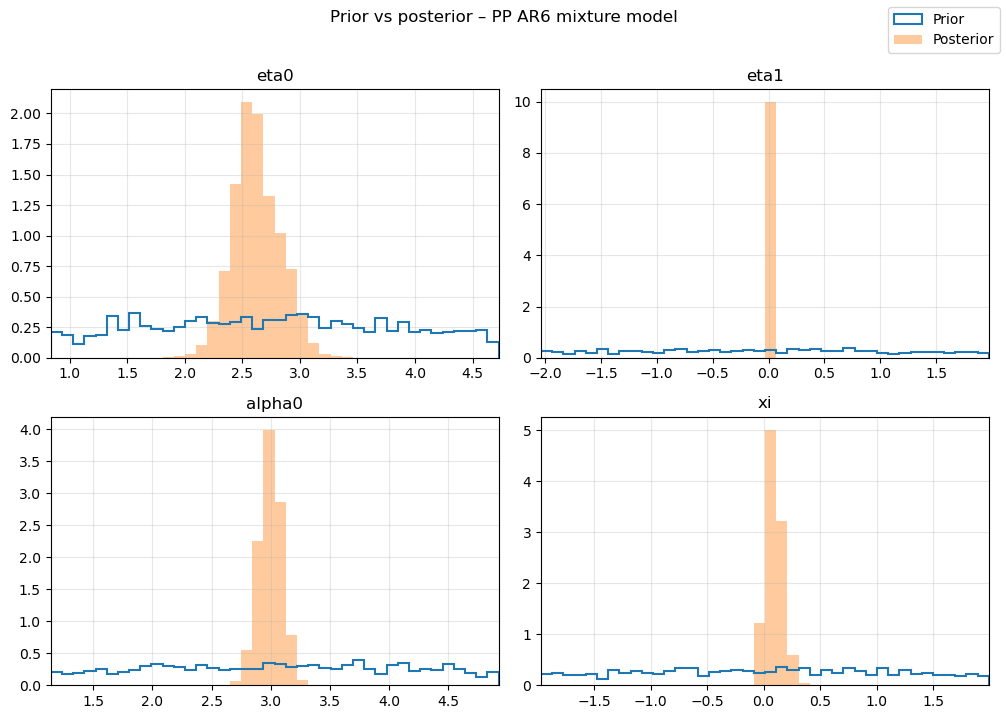

In [29]:
# CELL – Prior vs posterior plots for eta0, eta1, alpha0, xi (zoomed, clearer)

import matplotlib.pyplot as plt
import arviz as az
import numpy as np

params = ["eta0", "eta1", "alpha0", "xi"]

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.ravel()

for ax, p in zip(axes, params):
    # Prior samples (flatten chains × draws)
    prior_vals = prior_idata.prior[p].values
    prior_flat = prior_vals.reshape(-1)

    # Posterior samples
    post_vals = idata_pp.posterior[p].values
    post_flat = post_vals.reshape(-1)

    # Common x-range: central 99% of combined prior+posterior
    x_all = np.concatenate([prior_flat, post_flat])
    lo, hi = np.percentile(x_all, [0.5, 99.5])

    # Prior histogram (outline)
    ax.hist(
        prior_flat,
        bins=40,
        range=(lo, hi),
        density=True,
        histtype="step",
        linewidth=1.5,
        label="Prior",
    )

    # Posterior histogram (outline)
    ax.hist(
        post_flat,
        bins=40,
        range=(lo, hi),
        density=True,
        histtype="stepfilled",
        alpha=0.4,
        label="Posterior",
    )

    ax.set_xlim(lo, hi)
    ax.set_title(p)
    ax.grid(True, alpha=0.3)

# One legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

fig.suptitle("Prior vs posterior – PP AR6 mixture model", y=1.02)
plt.tight_layout()
plt.show()


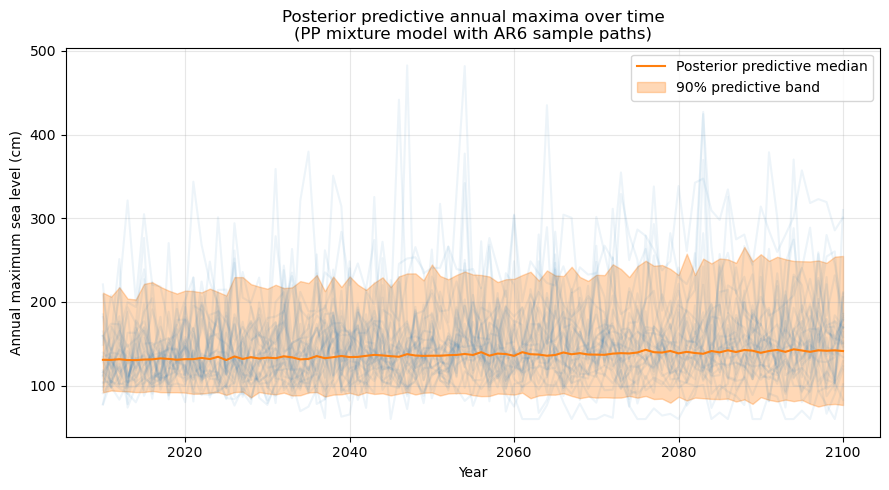

In [30]:
# CELL – Posterior predictive annual maxima over time using AR6 sample paths

import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load AR6 MSL ensemble (if not already loaded) ---

sl_data = np.load("data/varberg_sl_annual_2010_2200.npz")
years_sl = sl_data["years"]              # (N_years,)
sl_samples = sl_data["sl"].astype(float) # (N_paths, N_years)

# --- 2. Choose prediction period and extract MSL paths for those years ---

start_year, end_year = 2010, 2100
mask_pred = (years_sl >= start_year) & (years_sl <= end_year)
pred_years = years_sl[mask_pred]
X_pred_all_paths = sl_samples[:, mask_pred]      # shape (M_full, T)
M_full_pred, T = X_pred_all_paths.shape

# --- 3. Subsample climate paths to keep computation reasonable ---

M_pred = min(200, M_full_pred)  # number of AR6 paths to use for prediction
rng = np.random.default_rng(321)
sub_paths_idx = rng.choice(M_full_pred, size=M_pred, replace=False)
X_pred_paths = X_pred_all_paths[sub_paths_idx, :]  # (M_pred, T)

# --- 4. Flatten posterior draws for (eta0, eta1, alpha0, xi) ---

post = idata_pp.posterior
eta0_s   = post["eta0"].values.reshape(-1)
eta1_s   = post["eta1"].values.reshape(-1)
alpha0_s = post["alpha0"].values.reshape(-1)
xi_s     = post["xi"].values.reshape(-1)
n_total  = eta0_s.size

# --- 5. Simulate posterior predictive annual maxima along sample paths ---

u = 60.0          # threshold used in the PP model (cm)
n_scenarios = 1000 # number of (posterior draw, path) scenarios

draw_idx = rng.choice(n_total, size=n_scenarios, replace=True)
path_idx_for_scen = rng.choice(M_pred, size=n_scenarios, replace=True)

def simulate_annual_max_pp(eta0, eta1, alpha0, xi, X_t_series, u, rng):
    """Simulate one trajectory of annual maxima for a given parameter draw and MSL path."""
    sigma = np.exp(alpha0)
    T = X_t_series.shape[0]
    maxima = np.empty(T)
    for j in range(T):
        lam = np.exp(eta0 + eta1 * X_t_series[j])  # intensity for year j
        N = rng.poisson(lam)
        if N <= 0:
            # No exceedances: max is below u; represent as exactly u
            maxima[j] = u
        else:
            U = rng.uniform(size=N)
            if abs(xi) < 1e-6:
                # Approximate GPD with ξ ≈ 0 by exponential
                Z = -sigma * np.log(1.0 - U)
            else:
                # Inverse CDF for GPD: z = σ/ξ * ((1 - U)^(-ξ) - 1)
                Z = sigma / xi * ((1.0 - U) ** (-xi) - 1.0)
            maxima[j] = u + Z.max()
    return maxima

pred_maxima = np.empty((n_scenarios, T))
for s in range(n_scenarios):
    i = draw_idx[s]
    m = path_idx_for_scen[s]
    eta0   = eta0_s[i]
    eta1   = eta1_s[i]
    alpha0 = alpha0_s[i]
    xi     = xi_s[i]
    X_t_series = X_pred_paths[m, :]
    pred_maxima[s, :] = simulate_annual_max_pp(
        eta0, eta1, alpha0, xi, X_t_series, u=u, rng=rng
    )

# --- 6. Pointwise predictive summaries over time ---

q_low, q_med, q_high = np.percentile(pred_maxima, [5, 50, 95], axis=0)

plt.figure(figsize=(9, 5))

# Plot a few sample trajectories
for s in range(min(30, n_scenarios)):
    plt.plot(pred_years, pred_maxima[s, :], color="C0", alpha=0.08)

# Median and 90% predictive band
plt.plot(pred_years, q_med, color="C1", label="Posterior predictive median")
plt.fill_between(
    pred_years, q_low, q_high, color="C1", alpha=0.3, label="90% predictive band"
)

plt.xlabel("Year")
plt.ylabel("Annual maximum sea level (cm)")
plt.title("Posterior predictive annual maxima over time\n(PP mixture model with AR6 sample paths)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


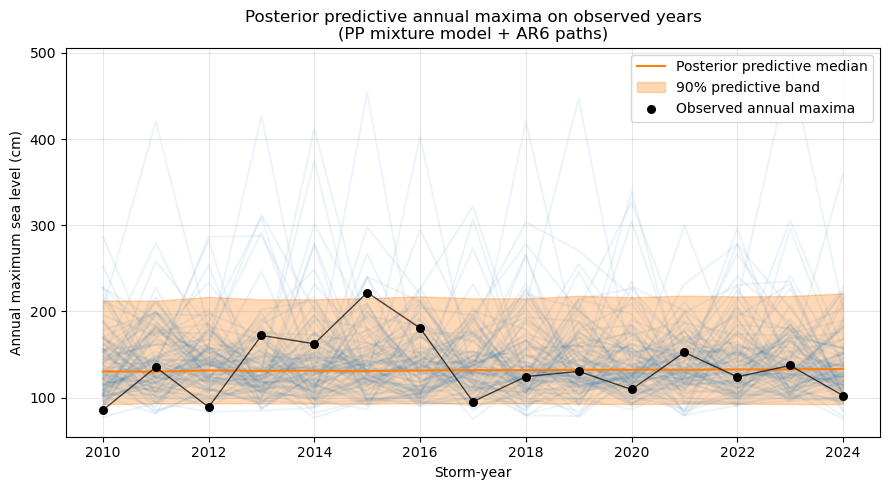

In [36]:
# CELL – Posterior predictive annual maxima on observed years + observations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import arviz as az

# -----------------------------
# 1. Load Halmstad data and compute observed annual maxima
# -----------------------------

file_path = "data/HALMSTAD SJÖV - RH 2000.csv"

df_full = pd.read_csv(file_path, sep=";", encoding="utf-8")
df_full["datetime"] = pd.to_datetime(df_full["Datum Tid (UTC)"])
df_full = df_full.set_index("datetime")
df_full = df_full[["Havsvattenstånd"]].rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to the same window as before (you can adjust if needed)
df_full = df_full.loc["2009-01-01":"2025-12-31"]

def storm_year(ts):
    y = ts.year
    return y if ts.month >= 7 else y - 1

series = df_full["sea_level_cm"].loc["2009-07-01":"2025-06-30"].dropna()

storm_year_index = series.index.to_series().apply(storm_year)
block_max_all = series.groupby(storm_year_index).max()          # index: storm_year (int)
years_data = block_max_all.index.values.astype(int)

# -----------------------------
# 2. Load AR6 ensemble and find overlapping years
# -----------------------------

sl_data = np.load("data/varberg_sl_annual_2010_2200.npz")
years_sl = sl_data["years"]                # (N_years,)
sl_samples = sl_data["sl"].astype(float)   # (N_paths, N_years)

years_sl_int = years_sl.astype(int)
overlap_years = np.intersect1d(years_data, years_sl_int)

if len(overlap_years) == 0:
    raise ValueError("No overlapping years between Halmstad data and AR6 ensemble.")

# Observed maxima for overlapping years
obs_max = block_max_all.reindex(overlap_years)

# AR6 MSL paths for overlapping years
year_to_idx_sl = {int(y): i for i, y in enumerate(years_sl)}
idxs_pred = np.array([year_to_idx_sl[int(y)] for y in overlap_years], dtype=int)

X_pred_all_paths = sl_samples[:, idxs_pred]   # (M_full_pred, T_obs)
M_full_pred, T_obs = X_pred_all_paths.shape

# -----------------------------
# 3. Subsample climate paths for prediction
# -----------------------------

rng = np.random.default_rng(321)
M_pred = min(100000, M_full_pred)
sub_paths_idx = rng.choice(M_full_pred, size=M_pred, replace=False)
X_pred_paths = X_pred_all_paths[sub_paths_idx, :]   # (M_pred, T_obs)

# -----------------------------
# 4. Flatten posterior draws
# -----------------------------

post = idata_pp.posterior
eta0_s   = post["eta0"].values.reshape(-1)
eta1_s   = post["eta1"].values.reshape(-1)
alpha0_s = post["alpha0"].values.reshape(-1)
xi_s     = post["xi"].values.reshape(-1)
n_total  = eta0_s.size

# -----------------------------
# 5. Simulate posterior predictive annual maxima
# -----------------------------

u = 60.0  # threshold used in the PP model (cm) – adjust if different

def simulate_annual_max_pp(eta0, eta1, alpha0, xi, X_t_series, u, rng):
    """Simulate one trajectory of annual maxima for a given parameter draw and MSL path."""
    sigma = np.exp(alpha0)
    T = X_t_series.shape[0]
    maxima = np.empty(T)
    for j in range(T):
        lam = np.exp(eta0 + eta1 * X_t_series[j])  # intensity for year j
        N = rng.poisson(lam)
        if N <= 0:
            maxima[j] = u  # no exceedances: max at threshold (below-threshold years)
        else:
            U = rng.uniform(size=N)
            if abs(xi) < 1e-6:
                Z = -sigma * np.log(1.0 - U)
            else:
                Z = sigma / xi * ((1.0 - U) ** (-xi) - 1.0)
            maxima[j] = u + Z.max()
    return maxima

n_scenarios = 10000  # number of (posterior draw, path) scenarios
draw_idx = rng.choice(n_total, size=n_scenarios, replace=True)
path_idx_for_scen = rng.choice(M_pred, size=n_scenarios, replace=True)

pred_maxima = np.empty((n_scenarios, T_obs))
for s in range(n_scenarios):
    i = draw_idx[s]
    m = path_idx_for_scen[s]
    eta0   = eta0_s[i]
    eta1   = eta1_s[i]
    alpha0 = alpha0_s[i]
    xi     = xi_s[i]
    X_t_series = X_pred_paths[m, :]
    pred_maxima[s, :] = simulate_annual_max_pp(
        eta0, eta1, alpha0, xi, X_t_series, u=u, rng=rng
    )

# -----------------------------
# 6. Predictive summaries and plot with observations
# -----------------------------

q_low, q_med, q_high = np.percentile(pred_maxima, [5, 50, 95], axis=0)

plt.figure(figsize=(9, 5))

# A few sample trajectories
for s in range(min(100,n_scenarios)):
    plt.plot(overlap_years, pred_maxima[s, :], color="C0", alpha=0.08)

# Predictive median and band
plt.plot(overlap_years, q_med, color="C1", label="Posterior predictive median")
plt.fill_between(
    overlap_years, q_low, q_high, color="C1", alpha=0.3, label="90% predictive band"
)

# Observed block maxima
plt.scatter(overlap_years, obs_max.values, color="k", s=30,
            label="Observed annual maxima", zorder=5)
plt.plot(overlap_years, obs_max.values, color="k", linewidth=1, alpha=0.7)

plt.xlabel("Storm-year")
plt.ylabel("Annual maximum sea level (cm)")
plt.title("Posterior predictive annual maxima on observed years\n(PP mixture model + AR6 paths)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


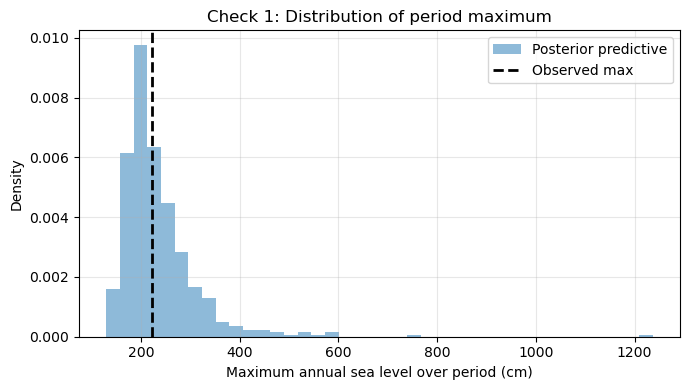

Observed max: 222.0 cm
Predictive 5/50/95%: [159.68531503 215.66389584 370.80775293]


In [32]:
# CELL 1 – Posterior predictive vs observed *maximum over the whole period*

import numpy as np
import matplotlib.pyplot as plt

# Convert obs_max to numpy array
obs_vals = np.asarray(obs_max.values if hasattr(obs_max, "values") else obs_max)

# Observed max over period
obs_overall_max = obs_vals.max()

# Predictive max over period for each scenario
pp_overall_max = pred_maxima.max(axis=1)   # shape (n_scenarios,)

plt.figure(figsize=(7, 4))
plt.hist(pp_overall_max, bins=40, density=True, alpha=0.5, label="Posterior predictive")
plt.axvline(obs_overall_max, color="k", linestyle="--", linewidth=2, label="Observed max")

plt.xlabel("Maximum annual sea level over period (cm)")
plt.ylabel("Density")
plt.title("Check 1: Distribution of period maximum")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Observed max: {obs_overall_max:.1f} cm")
print(f"Predictive 5/50/95%: {np.percentile(pp_overall_max, [5, 50, 95])}")


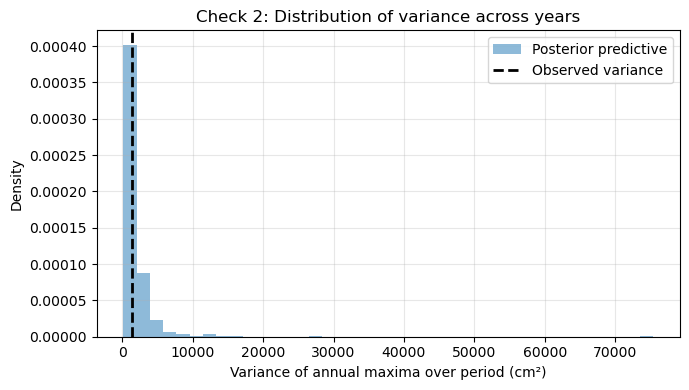

Observed variance: 1442.2
Predictive 5/50/95%: [ 395.10618945 1210.23897837 4617.11607124]


In [33]:
# CELL 2 – Posterior predictive vs observed variance of annual maxima

import numpy as np
import matplotlib.pyplot as plt

obs_vals = np.asarray(obs_max.values if hasattr(obs_max, "values") else obs_max)

# Observed variance over years
obs_var = obs_vals.var(ddof=1)

# Predictive variance over years for each scenario
pp_var = pred_maxima.var(axis=1, ddof=1)   # shape (n_scenarios,)

plt.figure(figsize=(7, 4))
plt.hist(pp_var, bins=40, density=True, alpha=0.5, label="Posterior predictive")
plt.axvline(obs_var, color="k", linestyle="--", linewidth=2, label="Observed variance")

plt.xlabel("Variance of annual maxima over period (cm²)")
plt.ylabel("Density")
plt.title("Check 2: Distribution of variance across years")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Observed variance: {obs_var:.1f}")
print(f"Predictive 5/50/95%: {np.percentile(pp_var, [5, 50, 95])}")


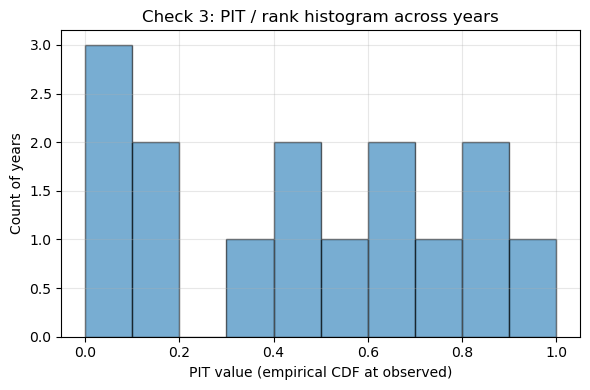

PIT values by year:
2010: 0.02
2011: 0.60
2012: 0.03
2013: 0.84
2014: 0.78
2015: 0.97
2016: 0.85
2017: 0.07
2018: 0.40
2019: 0.49
2020: 0.19
2021: 0.68
2022: 0.36
2023: 0.54
2024: 0.12


In [34]:
# CELL 3 – PIT / rank histogram for yearly calibration

import numpy as np
import matplotlib.pyplot as plt

# pred_maxima: (n_scenarios, T_obs)
# obs_max assumed indexed in the same order as overlap_years
obs_vals = np.asarray(obs_max.values if hasattr(obs_max, "values") else obs_max)
n_scenarios, T_obs = pred_maxima.shape

# PIT values: fraction of predictive samples <= observed, for each year
pit_vals = np.empty(T_obs)
for t in range(T_obs):
    pit_vals[t] = (pred_maxima[:, t] <= obs_vals[t]).mean()

plt.figure(figsize=(6, 4))
plt.hist(pit_vals, bins=10, range=(0, 1), edgecolor="k", alpha=0.6)
plt.xlabel("PIT value (empirical CDF at observed)")
plt.ylabel("Count of years")
plt.title("Check 3: PIT / rank histogram across years")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("PIT values by year:")
for year, pit in zip(overlap_years, pit_vals):
    print(f"{int(year)}: {pit:.2f}")


In [ ]:
# CELL – Save posterior + AR6 paths (historical + 2025–2100) for future predictive use

import numpy as np
import pandas as pd

import arviz as az

# -----------------------------
# 1. Load Halmstad data and compute observed annual maxima
# -----------------------------

file_path = "data/HALMSTAD SJÖV - RH 2000.csv"

df_full = pd.read_csv(file_path, sep=";", encoding="utf-8")
df_full["datetime"] = pd.to_datetime(df_full["Datum Tid (UTC)"])
df_full = df_full.set_index("datetime")
df_full = df_full[["Havsvattenstånd"]].rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to a reasonable window
df_full = df_full.loc["2009-01-01":"2025-12-31"]

def storm_year(ts):
    y = ts.year
    return y if ts.month >= 7 else y - 1

series = df_full["sea_level_cm"].loc["2009-07-01":"2025-06-30"].dropna()

storm_year_index = series.index.to_series().apply(storm_year)
block_max_all = series.groupby(storm_year_index).max()   # index: storm_year (int)
years_data = block_max_all.index.values.astype(int)

# -----------------------------
# 2. Load AR6 ensemble
# -----------------------------

sl_data = np.load("data/varberg_sl_annual_2010_2200.npz")
years_sl = sl_data["years"]                # (N_years,)
sl_samples = sl_data["sl"].astype(float)   # (N_paths, N_years)

years_sl_int = years_sl.astype(int)

# -----------------------------
# 3. Historical overlap: data years ∩ AR6 years
# -----------------------------

overlap_years = np.intersect1d(years_data, years_sl_int)

if len(overlap_years) == 0:
    raise ValueError("No overlapping years between Halmstad data and AR6 ensemble.")

# Observed maxima for overlapping years
obs_max_hist = block_max_all.reindex(overlap_years).values

# AR6 MSL paths for overlapping years (all ensemble members)
year_to_idx_sl = {int(y): i for i, y in enumerate(years_sl_int)}
idxs_hist = np.array([year_to_idx_sl[int(y)] for y in overlap_years], dtype=int)
X_hist_paths = sl_samples[:, idxs_hist]   # shape (M_paths, T_hist)

# -----------------------------
# 4. Future years 2025–2100: AR6 paths
# -----------------------------

start_future, end_future = 2025, 2100
mask_future = (years_sl_int >= start_future) & (years_sl_int <= end_future)
years_future = years_sl_int[mask_future]

if len(years_future) == 0:
    raise ValueError("No AR6 years in the range 2025–2100.")

idxs_future = np.where(mask_future)[0]
X_future_paths = sl_samples[:, idxs_future]   # shape (M_paths, T_future)

# -----------------------------
# 5. Flatten posterior samples from idata_pp
# -----------------------------

post = idata_pp.posterior

eta0_s   = post["eta0"].values.reshape(-1)
eta1_s   = post["eta1"].values.reshape(-1)
alpha0_s = post["alpha0"].values.reshape(-1)
xi_s     = post["xi"].values.reshape(-1)

u = 60.0  # threshold used in the PP model (cm) – adjust if different

print("Posterior draws:", eta0_s.shape[0])
print("Hist years:", overlap_years[0], "–", overlap_years[-1], "(T_hist =", X_hist_paths.shape[1], ")")
print("Future years:", years_future[0], "–", years_future[-1], "(T_future =", X_future_paths.shape[1], ")")
print("Number of AR6 paths:", X_hist_paths.shape[0])

# -----------------------------
# 6. Save everything needed for future predictive sampling
# -----------------------------

out_file = "data/pp_inputs_halmsdad_pp_mixture_2025_2100.npz"

np.savez(
    out_file,
    # posterior parameter draws
    eta0=eta0_s,
    eta1=eta1_s,
    alpha0=alpha0_s,
    xi=xi_s,
    u=u,
    # historical information
    years_hist=overlap_years,
    obs_max_hist=obs_max_hist,
    X_hist_paths=X_hist_paths,        # AR6 MSL paths for hist years
    # future information
    years_future=years_future,
    X_future_paths=X_future_paths,    # AR6 MSL paths for 2025–2100
)

print(f"Saved predictive inputs to: {out_file}")


Posterior draws: 64000
Hist years: 2010 – 2024 (T_hist = 15 )
Future years: 2025 – 2100 (T_future = 76 )
Number of AR6 paths: 20000
Saved predictive inputs to: pp_inputs_halmsdad_pp_mixture_2025_2100.npz


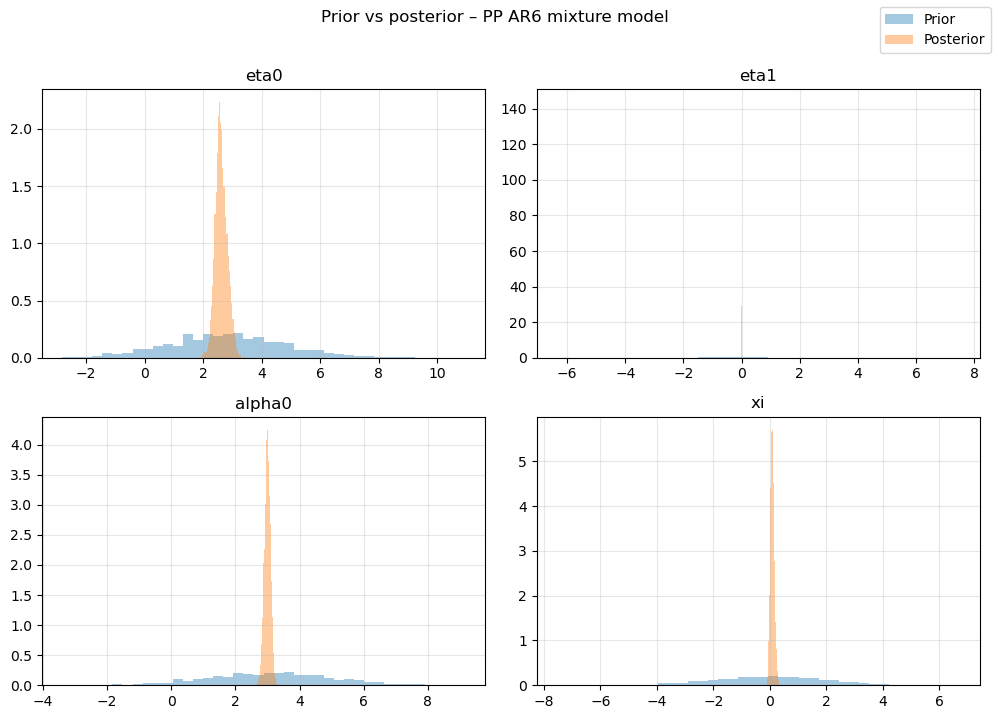

In [7]:
# CELL – Prior vs posterior plots for eta0, eta1, alpha0, xi

import matplotlib.pyplot as plt
import arviz as az
import numpy as np

params = ["eta0", "eta1", "alpha0", "xi"]

n_params = len(params)
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.ravel()

for ax, p in zip(axes, params):
    # Prior samples: shape (chain, draw) or (draw,)
    prior_vals = prior_idata.prior[p].values
    prior_flat = prior_vals.reshape(-1)

    # Posterior samples:
    post_vals = idata_pp.posterior[p].values
    post_flat = post_vals.reshape(-1)

    # Plot prior
    ax.hist(
        prior_flat,
        bins=40,
        density=True,
        alpha=0.4,
        label="Prior",
    )

    # Plot posterior
    ax.hist(
        post_flat,
        bins=40,
        density=True,
        alpha=0.4,
        label="Posterior",
    )

    ax.set_title(p)
    ax.grid(True, alpha=0.3)

# One legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

fig.suptitle("Prior vs posterior – PP AR6 mixture model", y=1.02)
plt.tight_layout()
plt.show()


In [4]:
# CELL – Load data and prepare POT counts, excesses, and sl_mean covariate (from scratch)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc as pm
try:
    import pytensor.tensor as pt
except ImportError:
    import aesara.tensor as pt

import arviz as az

# -------------------------------------------------
# 1. Load Halmstad sea-level data and define storm-years
# -------------------------------------------------

file_path = "data/HALMSTAD SJÖV - RH 2000.csv"

df_full = pd.read_csv(file_path, sep=";", encoding="utf-8")
df_full["datetime"] = pd.to_datetime(df_full["Datum Tid (UTC)"])
df_full = df_full.set_index("datetime")

df_full = df_full[["Havsvattenstånd"]].copy()
df_full = df_full.rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to a broad window and then to storm-years of interest (Jul–Jun)
df_full = df_full.loc["2009-01-01":"2025-12-31"]

def storm_year(ts):
    y = ts.year
    return y if ts.month >= 7 else y - 1

series = df_full["sea_level_cm"].loc["2009-07-01":"2025-06-30"].dropna()

# -------------------------------------------------
# 2. Declustered POT events (runs declustering)
# -------------------------------------------------

u = 60.0        # POT threshold in cm
run_hours = 24  # gap in hours for runs declustering

def runs_declustering(ts, values, u, run_hours=24.0):
    """
    Simple runs declustering:
      - ts: DatetimeIndex
      - values: array of sea levels (same length as ts)
      - u: threshold in cm
      - run_hours: minimum gap between clusters (in hours)
    Returns a DataFrame 'clusters' with one row per cluster maximum.
    """
    df = pd.DataFrame({"time": ts, "value": values})
    df = df.sort_values("time")
    exceed = df[df["value"] > u].copy()
    if exceed.empty:
        return pd.DataFrame(columns=["cluster_id", "start_time", "end_time",
                                     "max_time", "max_level", "storm_year"])

    exceed["gap_hours"] = exceed["time"].diff().dt.total_seconds().div(3600.0)
    new_cluster = (exceed["gap_hours"].isna()) | (exceed["gap_hours"] >= run_hours)
    exceed["cluster_id"] = new_cluster.cumsum()

    clusters_list = []
    for cid, grp in exceed.groupby("cluster_id"):
        start_time = grp["time"].min()
        end_time = grp["time"].max()
        max_row = grp.loc[grp["value"].idxmax()]
        max_time = max_row["time"]
        max_level = max_row["value"]
        sy = storm_year(max_time)
        clusters_list.append(
            {
                "cluster_id": int(cid),
                "start_time": start_time,
                "end_time": end_time,
                "max_time": max_time,
                "max_level": float(max_level),
                "storm_year": int(sy),
            }
        )
    return pd.DataFrame(clusters_list)

clusters = runs_declustering(series.index, series.values, u=u, run_hours=run_hours)
print("Number of declustered clusters above u:", len(clusters))
print(clusters.head())

# -------------------------------------------------
# 3. Yearly counts N_t for POT events
# -------------------------------------------------

clusters["storm_year"] = clusters["storm_year"].astype(int)
counts_per_year = clusters.groupby("storm_year").size().rename("N_t")

print("\nCounts per storm-year (first rows):")
print(counts_per_year.head())

# -------------------------------------------------
# 4. Load Varberg MSL ensemble and compute sl_mean per year
# -------------------------------------------------

sl_data = np.load("data/varberg_sl_annual_2010_2200.npz")
years_sl = sl_data["years"]              # (N_years,)
sl_samples = sl_data["sl"].astype(float) # (N_paths, N_years)

sl_mean_all = sl_samples.mean(axis=0)    # (N_years,)

sl_df = pd.DataFrame(
    {"storm_year": years_sl.astype(int), "sl_mean": sl_mean_all}
)

# -------------------------------------------------
# 5. Merge counts and sl_mean, restrict to overlapping years
# -------------------------------------------------

df_pp = pd.merge(
    counts_per_year.reset_index(),  # columns: storm_year, N_t
    sl_df,
    on="storm_year",
    how="inner",
).sort_values("storm_year")

print("\nData for Poisson part (first rows):")
print(df_pp.head())

# Arrays for Poisson part
storm_years_used = df_pp["storm_year"].values.astype(int)
N_t = df_pp["N_t"].values.astype("int32")
sl_mean_t = df_pp["sl_mean"].values.astype(float)

# -------------------------------------------------
# 6. Prepare excesses for GPD part (same overlapping years)
# -------------------------------------------------

clusters_gpd = clusters[clusters["storm_year"].isin(storm_years_used)].copy()
clusters_gpd = clusters_gpd[clusters_gpd["max_level"] > u].copy()
clusters_gpd["excess"] = clusters_gpd["max_level"] - u

excesses_np = clusters_gpd["excess"].values.astype(float)

print(f"\nNumber of years used: {len(storm_years_used)}")
print(f"Number of declustered events above u (for GPD): {len(excesses_np)}")
print("First few (year, N_t, sl_mean):", list(zip(storm_years_used[:5], N_t[:5], sl_mean_t[:5])))

# Now you have:
#   - storm_years_used: years used in the model
#   - N_t: yearly counts of declustered POT events
#   - sl_mean_t: mean sea level covariate per year (cm)
#   - excesses_np: all excesses above u for GPD fitting


Number of declustered clusters above u: 249
   cluster_id          start_time            end_time            max_time  \
0           1 2009-09-05 18:00:00 2009-09-05 23:00:00 2009-09-05 20:00:00   
1           2 2009-09-28 16:00:00 2009-09-28 16:00:00 2009-09-28 16:00:00   
2           3 2009-10-03 17:00:00 2009-10-05 09:00:00 2009-10-04 18:00:00   
3           4 2009-10-07 10:00:00 2009-10-07 13:00:00 2009-10-07 11:00:00   
4           5 2009-10-08 20:00:00 2009-10-09 00:00:00 2009-10-08 21:00:00   

   max_level  storm_year  
0       69.6        2009  
1       60.8        2009  
2      137.4        2009  
3       66.6        2009  
4       84.1        2009  

Counts per storm-year (first rows):
storm_year
2009    10
2010     7
2011    21
2012    11
2013    13
Name: N_t, dtype: int64

Data for Poisson part (first rows):
   storm_year  N_t    sl_mean
0        2010    7  27.854700
1        2011   21  30.009675
2        2012   11  32.164650
3        2013   13  34.319625
4        2014   1

In [5]:
# CELL 2 – Poisson–GPD model with sl_mean_t as covariate (no AR6 mixture)

import pymc as pm
try:
    import pytensor.tensor as pt
except ImportError:
    import aesara.tensor as pt
import arviz as az
import numpy as np

# Backend tensors
N_t_const      = pt.as_tensor_variable(N_t)           # shape (K_years,)
sl_mean_const  = pt.as_tensor_variable(sl_mean_t)     # shape (K_years,)
excesses_const = pt.as_tensor_variable(excesses_np)   # shape (n_events,)

def gpd_logpdf(e, sigma, xi):
    """
    Log-density of GPD(e | sigma, xi) for excess e >= 0:

        f(e) = 1/sigma * (1 + xi * e / sigma)^(-1/xi - 1)

    Works elementwise; e, sigma, xi can broadcast.
    """
    e = pt.as_tensor_variable(e)
    sigma = pt.as_tensor_variable(sigma)
    xi = pt.as_tensor_variable(xi)

    z = 1.0 + xi * e / sigma
    log_sigma = pt.log(sigma)
    inv_xi = 1.0 / xi

    logp = -log_sigma - (inv_xi + 1.0) * pt.log(z)
    logp = pt.switch(z <= 0.0, -np.inf, logp)
    return logp

with pm.Model() as pp_sl_model:
    # --- Occurrence model: N_t ~ Poisson(Λ_t), log Λ_t = η0 + η1 * sl_mean_t ---

    N_mean = float(N_t.mean() + 1e-3)
    eta0 = pm.Normal("eta0", mu=np.log(N_mean), sigma=2.0)
    eta1 = pm.Normal("eta1", mu=0.0, sigma=2.0)  # effect of sl_mean in cm

    log_Lambda_t = eta0 + eta1 * sl_mean_const
    Lambda_t = pm.Deterministic("Lambda_t", pt.exp(log_Lambda_t))

    N_obs = pm.Poisson("N_obs", mu=Lambda_t, observed=N_t_const)

    # --- GPD tail model: Z ~ GPD(σ, ξ), constant over years ---

    exc_mean = float(excesses_np.mean())
    alpha0 = pm.Normal("alpha0", mu=np.log(max(exc_mean, 1.0)), sigma=1.0)
    sigma = pm.Deterministic("sigma", pt.exp(alpha0))
    xi = pm.Normal("xi", mu=-0.1, sigma=0.2)

    logf_gpd = gpd_logpdf(excesses_const, sigma, xi)
    loglik_gpd = pt.sum(logf_gpd)

    pm.Potential("gpd_loglik", loglik_gpd)

    # --- Sample ---
    idata_pp_sl = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        chains=4,
        cores=4,
        random_seed=123,
        return_inferencedata=True,
    )

# Diagnostics
print(
    az.summary(
        idata_pp_sl,
        var_names=["eta0", "eta1", "alpha0", "xi"],
        round_to=3,
    )
)


c:\Users\johan\miniconda3\envs\flood_pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta0, eta1, alpha0, xi]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
eta0    2.175  0.312   1.578    2.747      0.005    0.004  3297.807  3307.944   
eta1    0.014  0.007   0.001    0.027      0.000    0.000  3275.110  3554.376   
alpha0  3.017  0.092   2.845    3.194      0.001    0.001  4071.900  4244.589   
xi      0.070  0.064  -0.042    0.195      0.001    0.001  4040.800  3882.762   

        r_hat  
eta0    1.001  
eta1    1.001  
alpha0  1.000  
xi      1.001  
